# Correlated Truncation Errors in for Realistic NN Interactions in Chiral Effective Field Theory

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.


*Note*: Since publication we have switched the `pivoted_cholesky` function from an underlying GSL to a LAPACK routine.
Their output is generally identical but the exact results can differ very slightly depending on fine details of the input matrix.
Thus some of the PC plots may not be identical to their published versions, but the overall conclusions remain unchanged. (Currently only Fig. 7(c) has changed.)

In [1]:
import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import urllib
import tables

%matplotlib inline

In [2]:
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

In [3]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
light_colors = [cmap(0.25) for cmap in cmaps]

edgewidth = 0.6

In [4]:
def regular_train_test_split(x, dx_train, dx_test, offset_train=0, offset_test=0, xmin=None, xmax=None):
    train_mask = np.array([(i - offset_train) % dx_train == 0 for i in range(len(x))])
    test_mask = np.array([(i - offset_test) % dx_test == 0 for i in range(len(x))])
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    train_mask = train_mask & (x >= xmin) & (x <= xmax)
    test_mask = test_mask  & (x >= xmin) & (x <= xmax) & (~ train_mask)
    return train_mask, test_mask

In [5]:
def offset_xlabel(ax):
    ax.set_xticks([0])
    ax.set_xticklabels(labels=[0], fontdict=dict(color='w'))
    ax.tick_params(axis='x', length=0)
    return ax

## NN Scattering in Chiral EFT

In the last section of the paper we turn our attention to NN scattering in Chiral EFT. We apply the above ideas to the differential cross section vs angle at $E_{\rm lab}=150$ MeV, to the total cross section vs energy, and to the spin observable $A$ at 96 MeV.

In [6]:
# Constants: proton/neutron masses and hbar
m_p = 938.27208  # MeV/c^2
m_n = 939.56541  # MeV/c^2
hbarc = 197.33  # Mev-fm


def E_to_p(E_lab, interaction):
    """Return p in MeV.

    Parameters
    ----------
    energy      = float
                  lab energy given in MeV.
    interaction = str
                  {"pp", "nn", "np"}
    """

    if interaction == "pp":
        m1, m2 = m_p, m_p
    if interaction == "nn":
        m1, m2 = m_n, m_n
    if interaction == "np":
        m1, m2 = m_n, m_p
    p_rel = np.sqrt(
        E_lab * m2**2 * (E_lab + 2 * m1) /
        ((m1 + m2)**2 + 2 * m2 * E_lab)
        )
    return p_rel


def Q_approx(E, Lambda_b, interaction='np', single_expansion=False):
    if single_expansion:
        m_pi = 0
    else:
        m_pi = 138  # Set to 0 to just return p/Lambda_b
    # Interpolate to smooth the transition from m_pi to p
    n = 8
    p = E_to_p(E, interaction)
    q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
    return q

Residuals plot (total cross-section)

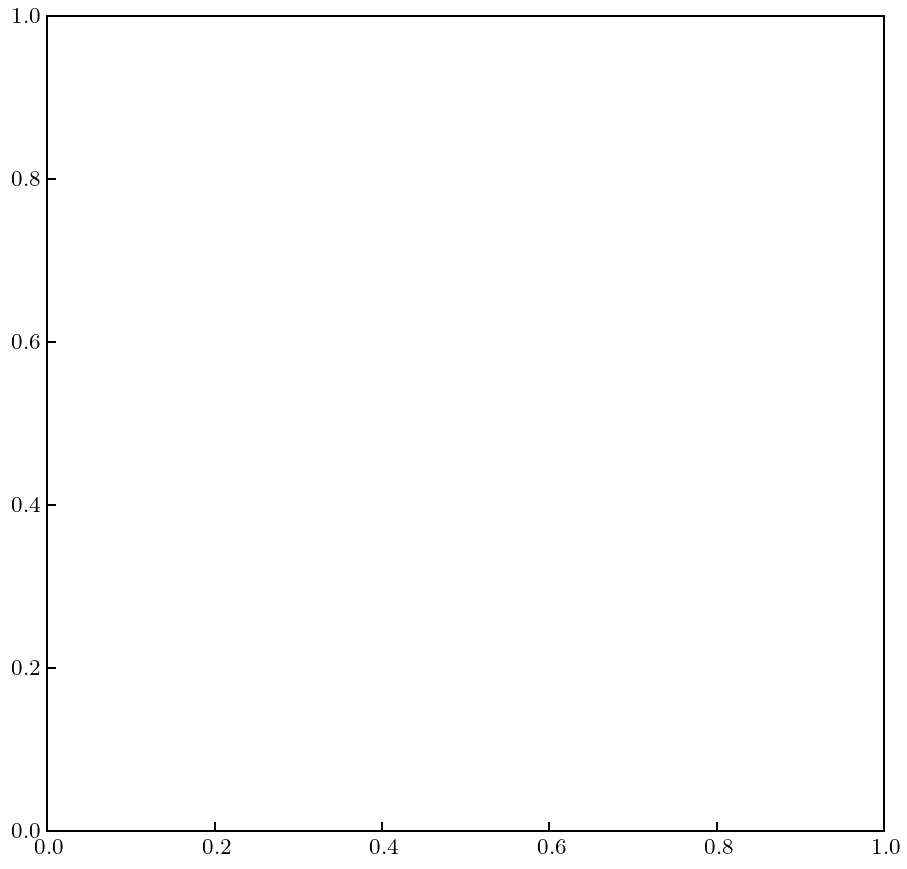

In [7]:
links_array = ['https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-0p8fm.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-0p9fm.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-1p0fm.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-1p1fm.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EKM_R-1p2fm.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EM-450MeV.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EM-500MeV.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_EM-550MeV.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_RKE_L-400MeV.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_RKE_L-450MeV.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_RKE_L-500MeV.h5?raw=true', \
              'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_RKE_L-550MeV.h5?raw=true']

labels_array = ['EKM0.8(4)', 'EKM0.9(4)', 'EKM1.0(4)', 'EKM1.1(4)', 'EKM1.2(4)', \
               'EMN450(4)', 'EMN500(4)', 'EMN550(4)', \
               'RKE400(4+)', 'RKE450(4+)', 'RKE500(4+)', 'RKE550(4+)']

colors_array = ['maroon', 'firebrick', 'red', 'tomato', 'lightcoral', \
               'palegreen', 'lime', 'forestgreen', \
               'lightskyblue', 'aqua', 'royalblue', 'navy']

fig, ax = plt.subplots(figsize = (6, 6))

In [8]:
# We get the NN data from a separate place in our github respository.
nn_url = links_array[11]
print(nn_url)

response = urllib.request.urlopen(nn_url) 
h5file = tables.open_file("nn_observables_eft.h5", driver="H5FD_CORE",
                          driver_core_image=response.read(),
                          driver_core_backing_store=0)
SGT = np.array(h5file.get_node('/SGT').read())
t_lab = h5file.get_node('/t_lab').read()
print(list(SGT[-1]))

https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_RKE_L-550MeV.h5?raw=true
[4262.62958986159, 2917.623590950503, 2295.187599679262, 1908.076988652594, 1636.0009667423792, 1431.566387663435, 1271.269711787036, 1141.76025613304, 1034.74905863228, 944.7578929898974, 867.993156148274, 801.73190079716, 743.9616753161426, 693.1597685353611, 648.1507263876575, 608.0112517753889, 572.005675929663, 539.540159949728, 510.1295957710662, 483.37372607022604, 458.93952015737983, 436.5473375578087, 415.9605274525831, 396.97748973165375, 379.42561767837265, 363.1560974190443, 348.0398615837274, 333.96441208009685, 320.83132266539184, 308.5542283870648, 297.0568705878334, 286.2716382864804, 276.13837457678454, 266.60340061960864, 257.61880441644155, 249.1415982276801, 241.13304778435577, 233.55815860418696, 226.38523563964682, 219.58552552019836, 213.13299011934885, 207.003917513383, 201.17663050898622, 195.6312726730148, 190.34962096403797, 185.31492278489867, 180.51

In [9]:
SGT = np.array([[4262.354672501544, 2917.167533942898, 2294.92006730853, 1908.0133483460936, 1636.1108746004804, 1431.8156182290168, 1271.6291626915615, 1142.2054285147424, 1035.2608824212407, 945.3203656279537, 868.5936438194535, 802.3601826180806, 744.609280596247, 693.8196508222779, 648.8172381031657, 608.6798700424723, 572.6724055783869, 540.2015637453043, 510.78309247513147, 484.0173518817003, 459.57146276976334, 437.1658667943342, 416.5643139353612, 397.5657288475585, 379.9976710218139, 363.7113868375518, 348.5778632451393, 334.4846683813603, 321.33359779629745, 309.03843040609195, 297.5230061377155, 286.71979788412864, 276.56871766817676, 267.01611902819934, 258.01396611276283, 249.51928319316676, 241.49347744784492, 233.9016733407285, 226.71227785443153, 219.89660087986132, 213.42852833999984, 207.28424017243736, 201.44196699165016, 195.88186409148702, 190.58584987185938, 185.53729558149837, 180.72088229351678, 176.12247283922295, 171.72899901126195, 167.5283621470438, 163.50934544723927, 159.6615366462819, 155.9752779984982, 152.44169561045013, 149.05254311616312, 145.80012131994224, 142.67723394044384, 139.67714630230375, 136.79354837053597, 134.02052166559747, 131.3525096504505, 128.78429124089635, 126.31095715764366, 123.92791994504734, 121.63093590687237, 119.41600680188967, 117.27935802205282, 115.21742240595908, 113.2268255959326, 111.30437281703286, 109.44703693843749, 107.65194769332051, 105.91638195018776, 104.2377549469882, 102.61361242070902, 101.04164323506245, 99.51970709501957, 98.04577282601811, 96.61790620821107, 95.23426374047108, 93.89308695531294, 92.59269727306646, 91.33149134178943, 90.10793681594136, 88.92056853301624, 87.76798505342083, 86.64884553528363, 85.56186692318705, 84.5058247780084, 83.47958404712158, 82.48207616267206, 81.51227651943643, 80.56920213355693, 79.65190921102439, 78.75949095555568, 77.89107558971574, 77.04582456697548, 76.22293095553081, 75.42161797740147, 74.64113768880881, 73.88076979024844, 73.13982055724681, 72.41762188578525, 71.7135355903772, 71.02697568924255, 70.35738601011134, 69.7042301949738, 69.06699063488692, 68.44516743309084, 67.8382774775798, 67.24585361011502, 66.66744388079513, 66.10261087896397, 65.55093113256905, 65.01199456921906, 64.48540403321589, 63.97077485382056, 63.467734461023674, 62.97592204623053, 62.49498990485285, 62.024619451234074, 61.56451275147761, 61.11438126247729, 60.673945200960745, 60.242933053773704, 59.82108114486261, 59.40813325161055, 59.00384026448212, 58.60795988494207, 58.220256357349925, 57.840500231157726, 57.4684681502362, 57.10394266660063, 56.74671207621189, 56.39657027491352, 56.053316632967615, 55.71675588798132, 55.38670260441332, 55.06299080475113, 54.7454618746119, 54.43396142630503, 54.1283390404273, 53.82844804038383, 53.534145295168045, 53.24529104666876, 52.96174875842229, 52.68338498323663, 52.41006924748639, 52.14167395018472, 51.87807427517993, 51.619148115029255, 51.364776005278856, 51.114841068027786, 50.869228963796054, 50.62782785084329, 50.390528352183004, 50.15722687114642, 49.92783253161608, 49.70225858193128, 49.48042023762394, 49.26223454934941, 49.04762028876599, 48.83649784977918, 48.62878916307809, 48.424417622259206, 48.22330802011443, 48.02538649385885, 47.83058047825328, 47.63881866569229, 47.45003097244103, 47.264148510286915, 47.081103562937585, 46.90082956655254, 46.72326109383364, 46.54833384112761, 46.375984618001915, 46.206152124998646, 46.0387832531724, 45.873829397015456, 45.71124290648378, 45.55097699683654, 45.39298568495215, 45.237223734650684, 45.08364660978312, 44.932210434072594, 44.782871956864014, 44.63558852406296, 44.49031805364258, 44.3470190151769, 44.20565041291371, 44.06617177195164, 43.928543127119305, 43.792725014180284, 43.65867846300592, 43.52636499236296, 43.39574660595874, 43.26678578936818, 43.139445479099464, 43.013691220322116, 42.88949449641162, 42.76682796922869, 42.64566471884448, 42.52597820467767, 42.40774223224577, 42.29093092473984, 42.175518698782426, 42.06148024383989, 41.94879050483953, 41.83742466761169, 41.72735814682019, 41.61856657608457, 41.511025800028335, 41.404711868006416, 41.29960102928399, 41.19566972944611, 41.09289460782516, 40.991252495727764, 40.89072041523573, 40.79127557833511, 40.69289538609758, 40.59555739164033, 40.4992418429118, 40.403932613246134, 40.30961395233022, 40.21627029287194, 40.12388622891559, 40.032446497285314, 39.94193596173454, 39.85233959945471, 39.763642489653726, 39.67582980395946, 39.58888679843503, 39.50279880701835, 39.4175512362201, 39.333129560925904, 39.249519321163305, 39.16670611969713, 39.08467562032612, 39.00341354674958, 38.922905681872656, 38.843137867410036, 38.764096003635174, 38.685766049101204, 38.608134020130066, 38.53118595668402, 38.454910236937515, 38.37929749387199, 38.304338492152525, 38.23002407072797, 38.156345130238414, 38.08329262221122, 38.01085753981385, 37.93903090997373, 37.86780378670469, 37.79716724550226, 37.72711237868765, 37.657630291594685, 37.5887120995035, 37.52034892523199, 37.452531897303174, 37.38525214860878, 37.31850081549179, 37.252269037169626, 37.1865479554182, 37.12132871443087, 37.05660246075849, 36.99236034322493, 36.92859351269344, 36.86529312153644, 36.80245032590165, 36.74005831085187, 36.678111564628885, 36.61660461038107, 36.555531993853414, 36.49488827602765, 36.43466802678181, 36.37486581944682, 36.31547622615672, 36.256493813905784, 36.197913141235446, 36.13972875548519, 36.081935190546695, 36.02452696506632, 35.967498581045454, 35.910844522789354, 35.85455925615883, 35.79863722807759, 35.743072866248525, 35.68786057903042, 35.63299475542249, 35.578469765099406, 35.52427995843272, 35.47041966642256, 35.41688320045092, 35.36366484297197, 35.31075905566749, 35.25816208438082, 35.20587065919237, 35.153881512208336, 35.10219137278097, 35.05079696336405, 34.99969499593045, 34.948882168891366, 34.89835516446498, 34.84811064645063, 34.79814525836768, 34.748455621923256, 34.69903833577713, 34.649889974572076, 34.60100708820181, 34.55238620128794, 34.504023812839236, 34.455916396064985, 34.40806039831528, 34.360452241116896, 34.31308832027449, 34.265965006000634, 34.21907864303473, 34.17242555070502, 34.12600202287783, 34.07980432772748, 34.03382869675086, 33.98807218057234, 33.94253280646566, 33.897208627378745, 33.85209768354846, 33.80719800006199, 33.762507584736156, 33.7180244262874, 33.67374649276525, 33.629671730228, 33.58579806163967, 33.542123385968935, 33.49864557747361, 33.4553624851526, 33.41227193235066, 33.369371716499245, 33.326659608978765, 33.28413335508575, 33.241790674089614, 33.199629259360975, 33.15764677855477, 33.11584087382687, 33.07420916206291, 33.032749235093526, 32.99145865986634, 32.95033497854007, 32.909375708456494, 32.8685783463875, 32.82794095524619], \
   [4262.5741921743065, 2917.337965965008, 2295.0482665776794, 1908.1095413329933, 1636.182695061833, 1431.8686593833672, 1271.6675631877747, 1142.232342118876, 1035.2787351614631, 945.3310748914107, 868.5987416840484, 802.3609060185739, 744.6066454799314, 693.8145001839564, 648.810274324002, 608.6716840975686, 572.6635001786377, 540.1923713460479, 510.77398449592545, 484.0086480491901, 459.56343988690844, 437.15876718547236, 416.5583553469616, 397.5611037819331, 379.9945479022508, 363.70991286371054, 348.57816766609966, 334.4868667869938, 321.3378007837488, 309.04473863403865, 297.5315081269121, 286.7305704797393, 276.5818271687956, 267.0316228344096, 258.03191536274215, 249.53973169567064, 241.51647608888095, 233.92726612542114, 226.74050138315673, 219.92748447092328, 213.46209462332905, 207.3205060765927, 201.48094516474177, 195.9235708431419, 190.6303034129079, 185.584509959642, 180.77086645848422, 176.1752302687799, 171.78452773642655, 167.58665508622866, 163.57039100546928, 159.72531957416538, 156.041782801687, 152.5109128359835, 149.12446165211608, 145.87472670345696, 142.7545077327116, 139.7570657991515, 136.87608656388383, 134.10564740450025, 131.44018797340914, 128.8744838699615, 126.40362316415346, 124.02302083014553, 121.72843713520219, 119.5158721597812, 117.38154885669204, 115.32189716113974, 113.33353955891678, 111.41327802729873, 109.55808222640302, 107.7650788291505, 106.03154189223802, 104.3548841881495, 102.73264944055275, 101.16252837751082, 99.64238442903078, 98.17018557455157, 96.74399616820524, 95.3619709069522, 94.02234928443455, 92.72345055300599, 91.46366915029638, 90.24147055013873, 89.05538750215999, 87.90401662956783, 86.7860153608501, 85.700099178821, 84.6450433707082, 83.61971685914047, 82.6230516545918, 81.65402271088915, 80.7116462835203, 79.79497759355725, 78.90310870998326, 78.0351666304805, 77.19031154261974, 76.36773524933592, 75.56665974457019, 74.78633592704601, 74.02604244242487, 73.28508464674381, 72.56279368735295, 71.85853210767885, 71.17171698911855, 70.50179265754835, 69.8482228679953, 69.21048991666795, 68.58809365729287, 67.9805506161706, 67.38739319584778, 66.80816895858341, 66.24243998188967, 65.6897822794216, 65.14978528140979, 64.62205136974998, 64.10619546381443, 63.601844654117066, 63.108637882256794, 62.62622782086581, 62.154298371373564, 61.692552560340374, 61.24070241006063, 60.79846855583074, 60.36557978732404, 59.94177264073502, 59.52679103584997, 59.120385953094804, 58.72231514630437, 58.33234288752898, 57.950239740677254, 57.57578236122509, 57.2087533196159, 56.84894094636919, 56.49613919731351, 56.15014753780876, 55.81077084749497, 55.47782492358948, 55.15114540099827, 54.83057451253469, 54.515958610807544, 54.20714792831848, 53.903996367074626, 53.60636131389484, 53.31410347826619, 53.027086750116474, 52.745178075253484, 52.468247346525665, 52.196167309014974, 51.928813477777176, 51.66606406683026, 51.40779992825409, 51.15390450041491, 50.90426376447323, 50.658766208484074, 50.41730280556224, 50.179771000440724, 49.946081151300106, 49.71614739094388, 49.489885753371546, 49.267214050575745, 49.04805176581678, 48.832319961125975, 48.619941197210125, 48.41083946423349, 48.20494012218822, 48.00216984974238, 47.80245660059619, 47.60572956649272, 47.411919146120574, 47.220956919224065, 47.03277562529907, 46.84730914630331, 46.664492492850904, 46.48426179338871, 46.30655428587157, 46.13130928899067, 45.95847469613984, 45.78800274615395, 45.61984658805964, 45.45396019832569, 45.290298320611015, 45.12881641405581, 44.969470608968095, 44.81221766895987, 44.65701495873957, 44.50382041688139, 44.35259253298294, 44.20329032869007, 44.055873342125615, 43.910301615298884, 43.766535684105534, 43.62453657055344, 43.484265776860845, 43.34568528107984, 43.208757533890115, 43.073445456187855, 42.939712414860715, 42.80752454782401, 42.676854071508615, 42.54767435603787, 42.419959164767775, 42.29368261675672, 42.16881915471881, 42.045343517691705, 41.92323071779428, 41.80245602055568, 41.682994928377674, 41.56482316675276, 41.447916672908555, 41.33225158658411, 41.217804242672706, 41.10455116548565, 40.99246906440665, 40.88153483071482, 40.771725535357064, 40.66301842744564, 40.55539093324576, 40.448820655394016, 40.34328537205341, 40.23876299216153, 40.13523418786494, 40.032683399990525, 39.931095438798906, 39.83045528160145, 39.73074805135537, 39.63195899840783, 39.5340734849563, 39.43707697187442, 39.34095500760579, 39.245693218877534, 39.151277303015554, 39.057693021670055, 38.96492619578175, 38.87296270163032, 38.78178846782087, 38.6913894730689, 38.60175174464844, 38.51286135736791, 38.424704432932586, 38.33726713954413, 38.25053569157103, 38.16449634910019, 38.07913541714457, 37.994439180639084, 37.910396299026544, 37.82699782276332, 37.74423492755335, 37.66209885251003, 37.58058088749517, 37.49967236230237, 37.419364637439664, 37.339649096310474, 37.26051713862342, 37.181960174886825, 37.103969621860436, 37.026536898854886, 36.94965342477559, 36.87331061581931, 36.797499883736286, 36.722212634573346, 36.647440267816044, 36.573174175846006, 36.49940574362685, 36.426126348525806, 36.353327360167285, 36.28100014020191, 36.20913604185188, 36.13772640906687, 36.06676253457659, 35.99623778640146, 35.926146933596776, 35.8564847729191, 35.78724611584409, 35.718425781095256, 35.650018588240854, 35.58201935222527, 35.51442287872309, 35.44722396022182, 35.380417372750756, 35.31399787318534, 35.24796019706148, 35.18229905684126, 35.11700914057637, 35.05208511091621, 34.98752160441114, 34.92331323106119, 34.85945457405875, 34.79594018967257, 34.73276460721623, 34.66992232903713, 34.60740783045508, 34.54521555956617, 34.483339936811355, 34.42177534393702, 34.36051629153779, 34.29955915252525, 34.23890082113686, 34.17853818767732, 34.11846813366358, 34.058687527640345, 33.99919322158527, 33.93998204783799, 33.88105081649578, 33.82239631322755, 33.76401529746231, 33.70590450091376, 33.64806062640613, 33.59048034696708, 33.533160305158844, 33.47609711261588, 33.41928734976037, 33.36272756566596, 33.30641427803931, 33.2503439732867, 33.19451310663146, 33.138918102243146, 33.08355535333451, 33.02842122217485, 32.97351203995894, 32.918824106456505, 32.864353669728665, 32.81009780113311, 32.756054603622, 32.70222220430208, 32.6485987127617, 32.59518221866673, 32.5419707896859, 32.48896246971544, 32.436155277374034, 32.383547204745824, 32.33113621634769, 32.278920248301944, 32.226897207695544, 32.17506497210786, 32.123421389290144, 32.07196427698037, 32.02069142283672, 31.969600584473298, 31.91868948958045, 31.867955836112408, 31.817397292522198, 31.76701149802288, 31.716796062850587, 31.66674856850344, 31.616866567922273, 31.567147585576663, 31.517589117408384, 31.468188634862166, 31.418944192153806], \
   [4262.844752242388, 2917.5393784107546, 2295.195273062211, 1908.2161646758898, 1636.2589889038923, 1431.921896457573, 1271.7030954539487, 1142.2542322499469, 1035.2901032627578, 945.3343844925073, 868.5959603554975, 802.3536240171624, 744.5961710594314, 693.8019224192167, 648.7965043350229, 608.6574915711304, 572.6495432477444, 540.1792222852943, 510.76213952734145, 483.9985375119943, 459.555438925565, 437.1532071552871, 416.5555400683695, 397.5613058611468, 379.9980080116229, 363.7168426461046, 348.58875376471974, 334.5012770525667, 321.3561993443848, 309.067276651107, 297.5583187855117, 286.7617688194532, 276.61751119804734, 267.0718756590164, 258.0768091308732, 249.5893429632929, 241.57087656683294, 233.9865154999024, 226.80464598126446, 219.99655706346888, 213.53611506850382, 207.3994826727601, 201.5648767783303, 196.0124601481543, 190.72415461940167, 185.68331874788424, 180.87461825070815, 176.28389943813647, 171.89807749158857, 167.7050378856975, 163.69354943065218, 159.85318765251057, 156.17429150639245, 152.64800076104285, 149.26606300823994, 146.02076856063638, 142.90490896711694, 139.91173658320014, 137.03492826716771, 134.26855282553427, 131.6070418580128, 129.04516370153297, 126.57800024140714, 124.20096837257044, 121.9098332963487, 119.70059141515102, 117.56946082902596, 115.5128659049829, 113.52742317496961, 111.60992853229585, 109.75734563037625, 107.966795390069, 106.23554653229195, 104.56100706917863, 102.94071671086044, 101.37236820043216, 99.85383031732437, 98.38306965974945, 96.95814835187339, 95.57721831558747, 94.2385159321714, 92.94035716700357, 91.68113312800301, 90.45930602752807, 89.27340551944837, 88.12202538713093, 87.00382056399839, 85.91750447667908, 84.861852155926, 83.83573878426597, 82.83809796893672, 81.86790480661307, 80.92417524545071, 80.00596388421394, 79.11236196072592, 78.24249551830583, 77.39552373802196, 76.57063742489146, 75.7670576371878, 74.98403444958551, 74.2208458429725, 73.4767967165576, 72.7512180217246, 72.0434742092653, 71.3529877897653, 70.67920511662679, 70.0215914417585, 69.37963026731865, 68.75282243263564, 68.14068528591528, 67.54275193442486, 66.95857056699862, 66.38770384310754, 65.82972834327732, 65.28423407630012, 64.75082403946077, 64.22911382892988, 63.71873129862709, 63.2193162673676, 62.73052309881973, 62.25204027487398, 61.783573609570574, 61.32483739821086, 60.875554343205046, 60.43545513283921, 60.00427806385999, 59.581768703813076, 59.167679589449776, 58.76176995788176, 58.36380550750916, 57.97355818609431, 57.59080600368771, 57.21533286846659, 56.846928443920035, 56.4853880262405, 56.1305124412907, 55.78210796467638, 55.43999303495394, 55.104006574396855, 54.773993298779054, 54.44980189828693, 54.13128481639493, 53.81829805494938, 53.510701002446964, 53.20835628294702, 52.91112962340599, 52.61888973750757, 52.33150822429501, 52.04885948011492, 51.770820622559256, 51.497271425255285, 51.228094262503, 50.96317406291279, 50.70239827134703, 50.44565681863974, 50.192842110319916, 49.94385361276557, 49.69860411628083, 49.45700994466251, 49.21898923661791, 48.984461828783054, 48.753349154329364, 48.52557415510613, 48.30106120563077, 48.07973604751317, 47.86152573310498, 47.646358577327774, 47.434164116761565, 47.224873075181726, 47.018417334816384, 46.814729912668646, 46.613744941307104, 46.41539765357584, 46.21962437071174, 46.02636249338706, 45.83555049520871, 45.647128937694916, 45.46104731803858, 45.27725963242333, 45.095720740293224, 44.91638628087552, 44.739212613297596, 44.56415676534405, 44.3911763896745, 44.22022972653205, 44.05127557213247, 43.88427325204019, 43.71918259893098, 43.555963934211505, 43.39457805302043, 43.23498621218003, 43.077150120695826, 42.92103193242522, 42.76659424054595, 42.613800073453625, 42.4626128917055, 42.31299658559536, 42.164915427014684, 42.01833626970025, 41.87323249980181, 41.72957875868691, 41.587350056777325, 41.44652173396945, 41.30706942598697, 41.16896903579301, 41.03219670936031, 40.896728815220925, 40.76254192731273, 40.62961281070709, 40.497918409859125, 40.36743583906029, 40.23814237480444, 40.11001544980152, 39.98303264838709, 39.85717170308331, 39.732410492068205, 39.6087270373007, 39.48609950303138, 39.36450619439815, 39.24392555575738, 39.12433602042163, 39.00571856211982, 38.888058434065506, 38.77134130082875, 38.65555298300879, 38.54067943332572, 38.42670671631659, 38.3136209911072, 38.20140849683395, 38.090055540361874, 37.97954848600501, 37.869873746994564, 37.76101777847412, 37.65296707182512, 37.54570815014395, 37.43922756470425, 37.33351189224575, 37.22854773293543, 37.12432170884342, 37.020820462770125, 36.9180306572487, 36.81593897352353, 36.714532110276544, 36.61379678182544, 36.513719483641616, 36.41428893470178, 36.31549669474414, 36.21733446447045, 36.11979400412827, 36.02286711860316, 35.92654564472641, 35.8308214404795, 35.73568637583689, 35.6411323250318, 35.547151160065425, 35.453734745303485, 35.360874933024405, 35.268563559798096, 35.1767924435838, 35.08555338144423, 34.99483814777686, 34.90463849296517, 34.81494614235113, 34.725752795425954, 34.63705012512826, 34.548829777125086, 34.46108336893374, 34.37380248871484, 34.286978693531296, 34.20060325970605, 34.114669513001026, 34.02917250472065, 33.94410731742314, 33.85946904802439, 33.775252798580986, 33.69145366840963, 33.608066747359494, 33.52508711008449, 33.442509811191, 33.36032988115181, 33.27854232289614, 33.197142108991805, 33.11612417934789, 33.03548343937001, 32.95521475850494, 32.875312969114326, 32.79577286561742, 32.716589203842204, 32.63775670052072, 32.5592700328613, 32.48112383812031, 32.40331271308784, 32.32583121338472, 32.24867385244828, 32.17183508379625, 32.095309239649644, 32.01909267281811, 31.943182404146466, 31.867575452980432, 31.7922688308716, 31.717259536169905, 31.642544549382276, 31.568120829198783, 31.49398530910541, 31.420134894513772, 31.346566460348953, 31.273276849042784, 31.20026286888759, 31.12752129270647, 31.05504885680279, 30.982842260150658, 30.91089816379072, 30.83921319039523, 30.76778392396627, 30.69660690962741, 30.625678653468405, 30.55499562239583, 30.484554243937257, 30.414350905937447, 30.344381956073132, 30.274643701095833, 30.205132324741438, 30.13584471335576, 30.066778989984766, 29.997933320375395, 29.92930585493097, 29.860894725395674, 29.792698041995568, 29.724713890982752, 29.65694033253763, 29.58937539899088, 29.522017093332376, 29.454863387977227, 29.387912223763134, 29.321161509154912, 29.254609119633816, 29.1882528972502, 29.122090650319382, 29.056120153239586, 28.99033914641185, 28.924745336239557, 28.85933639518549, 28.7941099618602, 28.72906364111451, 28.66419500410334, 28.599501588283225, 28.534980897298716, 28.47063040070155, 28.406447510175845, 28.342430125499913], \
   [4263.065992324571, 2917.686560124817, 2295.2962318481127, 1908.2844324554073, 1636.3031446294854, 1431.9478919588284, 1271.715234571086, 1142.2557551786467, 1035.2834926111877, 945.3216075318745, 868.5785952116966, 802.3329587285821, 744.5732800762314, 693.7777163432421, 648.7717602078608, 608.6328799510632, 572.6256524267187, 540.1565838097201, 510.74122998258906, 483.9797823289986, 459.53921977837547, 437.13987273086326, 416.5454277411309, 397.5547307678098, 379.9952569191723, 363.71817463025985, 348.59440334887546, 334.5114613792249, 321.37114072571086, 309.08718675701573, 297.583388882586, 286.79216787881694, 276.65338621541065, 267.1133537280204, 258.12400246791674, 249.64237205515224, 241.62985631013257, 234.0515436449096, 226.87580043879433, 220.07389500035214, 213.61967333701213, 207.48927936812325, 201.6609140119089, 196.11474342919135, 190.8326902791303, 185.79809917665273, 180.99561912550791, 176.41107833852678, 172.03137352596949, 167.84437211628762, 163.83882599316485, 160.0042955554369, 156.33111239436857, 152.81042462208268, 149.4339717918419, 146.194032271287, 143.08338413914407, 140.09526552365588, 137.2233388849922, 134.46165893685506, 131.80464390648052, 129.247049872872, 126.78394799288654, 124.41075558669274, 122.12324314125483, 119.91740103389829, 117.78943979822994, 115.7357753035218, 113.75301509396576, 111.8379459299319, 109.98752246898663, 108.19885701647428, 106.46921028090443, 104.7959830846802, 103.17670900660141, 101.60908258800629, 100.09097936701703, 98.62036437578566, 97.19529714182386, 95.81392633619151, 94.47448469371962, 93.17528434163636, 91.91471252465412, 90.69122770823735, 89.50335604079037, 88.3496881580844, 87.22887631889918, 86.13963187008052, 85.08073000333965, 84.0510542739571, 83.04954154458191, 82.0751684879541, 81.12695211450641, 80.20394772351102, 79.30524701163154, 78.42997633702757, 77.57729513332328, 76.74639446625896, 75.93649572582017, 75.14684944765435, 74.37673425952103, 73.62545595150947, 72.89234667319622, 72.17677439245016, 71.47816935268308, 70.79598227584896, 70.12968221450583, 69.47875614684675, 68.84270813202272, 68.2210585372233, 67.61334333377859, 67.01911345863911, 66.43793423732701, 65.86938486457858, 65.3130579393152, 64.76855905123989, 64.2355064172728, 63.713530567292985, 63.20227408039233, 62.701394791837906, 62.21058751775081, 61.72956319023016, 61.25804075367793, 60.795747337091115, 60.342417860176475, 59.897794678604335, 59.46162726553954, 59.033671926623995, 58.61369154572469, 58.201455358961645, 57.796738754779476, 57.39932309810728, 57.00899557696927, 56.625549070282815, 56.24878203602072, 55.87849841947381, 55.51450758618369, 55.15663174059333, 54.80471446768947, 54.458604884344695, 54.11815594184679, 53.78322421006109, 53.45366968732106, 53.129355633138076, 52.81014842124701, 52.49591741083477, 52.186534834070365, 51.88187569828045, 51.581817701309895, 51.28624115878008, 50.995028942114836, 50.70806642635311, 50.42524144691301, 50.14644426462218, 49.8715675384934, 49.60050631368157, 49.33316248662224, 49.0694520138406, 48.80929468233964, 48.55261202367077, 48.29932719110892, 48.04936485386425, 47.802651105918315, 47.559113387537764, 47.31868041785967, 47.081282137194364, 46.846849657886196, 46.61531522272331, 46.386612170005776, 46.16067490447592, 45.937438873389205, 45.71684054705901, 45.498817403252225, 45.28330791483199, 45.07025154005522, 44.85958871491002, 44.651261434544026, 44.44522064905628, 44.241422767970505, 44.0398250553248, 43.840385523058714, 43.64306286308345, 43.447816389545665, 43.25460598975485, 43.06339208254429, 42.8741355830556, 42.68679787309824, 42.50134077635939, 42.31772653783068, 42.13591780688836, 41.95587762351501, 41.77756940718383, 41.60095694794785, 41.42600439928095, 41.252676272202976, 41.08093743019022, 40.910753084310784, 40.74208865338296, 40.57491112806965, 40.40919503295011, 40.24491652835256, 40.082052143664505, 39.92057872866515, 39.760473412410605, 39.60171356844479, 39.444276785369226, 39.28814084199104, 39.133283686408205, 38.979683418491675, 38.82731827530407, 38.67616661904901, 38.526206927189044, 38.37741778439942, 38.22977787604283, 38.08326598285743, 37.937860976548656, 37.79354181595885, 37.65028754345728, 37.50807728114694, 37.36689022640683, 37.22670521888977, 37.08750283930796, 36.949269055816075, 36.811990387353454, 36.67565352012938, 36.54024527644228, 36.40575258828829, 36.272162474988015, 36.13946202421798, 36.007638375949185, 35.87667870888566, 35.74657022905658, 35.61730016026692, 35.48885573614728, 35.361224193569555, 35.234392767214025, 35.10834868508297, 34.9830791647628, 34.85857141023119, 34.73481260899648, 34.61178992933766, 34.48949051738081, 34.367901493703954, 34.247009949095, 34.12680232696074, 34.00726681505174, 33.88839533880103, 33.77018002212103, 33.65261306416878, 33.535686719021705, 33.419393278389364, 33.30372505688211, 33.188674379452955, 33.07423357070177, 32.9603949457838, 32.84715080270436, 32.73449341581386, 32.622415030337265, 32.510907857791004, 32.399964072150865, 32.28957580664116, 32.17973515101954, 32.07043414922885, 31.961664797283106, 31.853419041242816, 31.745688775116943, 31.638465838504512, 31.531742013750918, 31.425509022344755, 31.319757849173975, 31.21448137387644, 31.109674810253377, 31.00533342736498, 30.901452524626844, 30.79802741879066, 30.695053432800215, 30.592525886236512, 30.490440087123, 30.38879132490246, 30.287574864428564, 30.186785940840796, 30.086419755205938, 29.98647147082723, 29.886936210128468, 29.787809052029584, 29.68908502973375, 29.59075912884803, 29.4928262857589, 29.395281386180745, 29.298119263789744, 29.201334698845077, 29.104922416686016, 29.0088770859729, 28.913193316513073, 28.81786562905778, 28.722887940418733, 28.628256411736928, 28.533968143150673, 28.440020250391687, 28.34640985554552, 28.253134079108566, 28.160190033144602, 28.067574815383168, 27.975285504131538, 27.88331915389459, 27.79167279161335, 27.70034341344557, 27.60932798202298, 27.518623424124836, 27.428226628715535, 27.338134445295356, 27.24834368251729, 27.158851107023057, 27.069653442451393, 26.98074736856882, 26.892129520471187, 26.803796487796284, 26.715744813882154, 26.627970994792744, 26.540471478118064, 26.453242661434576, 26.366280692977856, 26.27958215920452, 26.19314523254491, 26.106968171002173, 26.0210492306239, 25.935386660322393, 25.84997869738841, 25.764823563603418, 25.679919461872775, 25.595264573315692, 25.51085705475806, 25.42669503658281, 25.342776620896245, 25.25909987997688, 25.175662854973034, 25.092463554820508, 25.00949995535206, 24.92676999857155, 24.844271592065837, 24.762002608526576, 24.67996088535313, 24.598144224304853, 24.516550391167698, 24.435177115395245, 24.354022089676835, 24.27308296937742, 24.192357371779465, 24.111842796682275, 24.031537017441263], \
   [4263.156191679073, 2917.7208042996294, 2295.3061529006923, 1908.2787250612153, 1636.2862915501491, 1431.9227752800634, 1271.6838777303485, 1142.2196772903546, 1035.2438672008182, 945.2793955423507, 868.534594381188, 802.2878518896117, 744.527672459239, 693.7321589468349, 648.7267562015935, 608.5888931378774, 572.5831197109889, 540.1159373341369, 510.7028854879391, 483.9441323730126, 459.506635095276, 437.1107105202474, 416.5200585896201, 397.5335180597232, 379.97854320079074, 363.706278790893, 348.58762195106135, 334.5100762115672, 321.3754493622461, 309.0974791934645, 297.59993200080066, 286.81520124279626, 276.6831211739326, 267.1499751219113, 258.16767453187015, 249.693269755306, 241.68814682715168, 234.11737006114282, 226.94927747277913, 220.15510724831918, 213.70867538616474, 207.5860974868364, 201.76554951417037, 196.22719817929908, 190.952964249997, 185.92617116008273, 181.13144293375754, 176.5545808537879, 172.18245409924157, 168.00290303452744, 164.00465387361714, 160.17724364079635, 156.51099043208555, 152.99704948673525, 149.62714758584133, 146.39354548132624, 143.28900177169666, 140.30673421086527, 137.44038473347993, 134.68398798070515, 132.03194308628076, 129.47898851226395, 127.02017979493304, 124.65093228343738, 122.36702133692397, 120.16442914883636, 118.03935635245166, 115.98820791856573, 114.00758001534876, 112.09424795709305, 110.245155218987, 108.45740347503809, 106.72824361589826, 105.05506771710995, 103.43540195652596, 101.86694259107541, 100.34757333110899, 98.87525854629081, 97.44805605882452, 96.06411219505571, 94.72165698207326, 93.41899969431451, 92.15452475667676, 90.92668799858878, 89.7340132493565, 88.57508926614823, 87.44856699134922, 86.35315714615271, 85.2876366492217, 84.25089958176387, 83.24188889575487, 82.25958575431217, 81.30301117423934, 80.3712241162485, 79.46331970334887, 78.57842757420613, 77.71571037170187, 76.87436236379098, 76.05360819277197, 75.25270174959644, 74.47092517162419, 73.70758796538948, 72.96202626092963, 72.23361395211279, 71.52179133434625, 70.82601691813923, 70.14576705900905, 69.480535730211, 68.82983372392675, 68.19318791570252, 67.57014059172184, 66.96024883690305, 66.36308398111825, 65.77823110068908, 65.2052885725733, 64.6438676792349, 64.09359226309645, 63.55409843077894, 63.025034309207605, 62.506063539772725, 61.99688860947415, 61.49722833447498, 61.00680928035414, 60.52536599184004, 60.05264060280816, 59.588382485401674, 59.13234793539424, 58.68429989095606, 58.244007682132164, 57.81124680854198, 57.385798743063205, 56.967450759539034, 56.55599578286325, 56.151232260162516, 55.752964052222715, 55.361000344845735, 54.975155583623845, 54.59525647308918, 54.221152154333396, 53.852698075879, 53.48975341596568, 53.13218085006587, 52.7798463480111, 52.4326189968093, 52.09037084595158, 51.75297677253026, 51.42031436389437, 51.09226381587866, 50.76870784489726, 50.4495316124, 50.134622660362794, 49.823870856633114, 49.51716834908038, 49.214409527615054, 48.91549099324296, 48.62031152435365, 48.32877523490017, 48.04080136826228, 47.75631411103543, 47.47523936233847, 47.19750458929437, 46.923038703957225, 46.651771958196804, 46.3836358538103, 46.11856306567563, 45.85648737615107, 45.597343619215266, 45.3410676330599, 45.08759622000778, 44.83686711274904, 44.5888189459742, 44.3433912325351, 44.100524343289585, 43.86015948977192, 43.622238708785034, 43.386704847902195, 43.15350108346173, 42.92257902269839, 42.693897689766224, 42.467417012771385, 42.24309766734743, 42.02090099140495, 41.800788913161824, 41.58272389023049, 41.36666885801379, 41.152587186002954, 40.94044264082004, 40.73019935503253, 40.52182180090101, 40.31527476832055, 40.11052334628377, 39.907532907235755, 39.706269093709096, 39.50669780662119, 39.308785194579656, 39.11249764347266, 38.91780176550647, 38.72466409416113, 38.533050816912436, 38.342937170195, 38.15430070307509, 37.96711936852578, 37.78137145925297, 37.59703555371121, 37.41409047050644, 37.23251522978569, 37.05228902050364, 36.87339117266798, 36.69580113382031, 36.51949844912669, 36.34446274453377, 36.1706737125095, 35.99811109992753, 35.8267546976793, 35.65658433160472, 35.4875798543261, 35.319721137540554, 35.152988064278915, 34.98736052055982, 34.82281838575315, 34.65934066263028, 34.49690675978244, 34.33550305261589, 34.175116696891486, 34.01573505510981, 33.85734565453227, 33.699936151672155, 33.54349430213672, 33.388007934944085, 33.23346493061297, 33.079853202457265, 32.92716068061122, 32.77537529838517, 32.62448498060394, 32.474477633619514, 32.32534113671524, 32.177063334634155, 32.02963203097123, 31.883034982163785, 31.73725989179922, 31.592294404932325, 31.448126102058627, 31.304742492327215, 31.16213100548174, 31.020277849056438, 30.87917024049753, 30.73880029646761, 30.599160425043394, 30.460243147063775, 30.322041068574958, 30.184546857347883, 30.04775322278464, 29.911652898675552, 29.776238628373193, 29.641503152029074, 29.507439195597716, 29.37403946135755, 29.24129661973058, 29.10920330220717, 28.97775209519965, 28.846935534657703, 28.71674610128456, 28.58717621619017, 28.458218236811454, 28.329864452914713, 28.202107082471645, 28.074938267167862, 27.94835006725284, 27.822334455375266, 27.69688211390467, 27.571985365859653, 27.44763958609317, 27.32384024616593, 27.20058287977879, 27.07786306508405, 26.955676409483736, 26.834018536516698, 26.71288507451494, 26.59227164677317, 26.47217386301783, 26.352587311999898, 26.2335075550587, 26.1149301205257, 25.996850498850723, 25.879264138343206, 25.762166441428214, 25.645552761319557, 25.52941839901227, 25.413758600493434, 25.298568554062953, 25.183843387643243, 25.069578165940275, 24.95576788729297, 24.842407480013, 24.72949175830126, 24.61701438907704, 24.50497147945905, 24.393360372131436, 24.282178453146887, 24.171423139308903, 24.061091867276833, 23.951182084118116, 23.841691239088963, 23.732616776467715, 23.623956129297284, 23.515706713917254, 23.407865925184876, 23.30043113229888, 23.193399675149422, 23.08676886112724, 22.98053596232871, 22.87469821309877, 22.76925280785389, 22.66419689912879, 22.559527595786843, 22.455241961331865, 22.351337012250713, 22.247809716308005, 22.1446569906999, 22.041875699956012, 21.939462653452814, 21.83741428362754, 21.735727157517065, 21.634399761988853, 21.533430717798467, 21.432818662370295, 21.332562242504828, 21.232660108012347, 21.133110906137304, 21.033913276665203, 20.93506584762286, 20.836567231498762, 20.738416021921736, 20.640610790744695, 20.543150085488005, 20.446032427100846, 20.349256308003724, 20.252820190377598, 20.156722504666124, 20.060961648259067, 19.965535984323683, 19.870443840749715, 19.77568350917132, 19.68125324402472, 19.587151261595046, 19.493375738997806, 19.399924813029745, 19.306796578808818, 19.213988954111915, 19.12149989122761], \
   [4262.466313636019, 2917.256032670357, 2294.8960989235225, 1907.8774292944167, 1635.8791649384686, 1431.5065374027297, 1271.258716637006, 1141.787921210014, 1034.8075197029289, 944.8410746932727, 868.0963165119173, 801.8513017863844, 744.0943462920726, 693.303321173034, 648.3032230419841, 608.171113911233, 572.1716067560649, 539.7110828091674, 510.3046149102599, 483.5520963719683, 459.12061406927654, 436.73062210759906, 416.14555039407975, 397.16386870310805, 379.61302526731043, 363.3442487155075, 348.2285086912268, 334.1533402438536, 321.020346596902, 308.74318362557875, 297.2456088706041, 286.4600262533626, 276.32629314135477, 266.79074464478714, 257.8054789849721, 249.32751457198992, 241.31812321343182, 233.74231702547166, 226.56840834652655, 219.76765204769308, 213.3140157779884, 207.18379072514847, 201.3553034276385, 195.80870218596263, 190.52576986583898, 185.489761063633, 180.68530814471146, 176.0983178321355, 171.71577028915846, 167.52561428617224, 163.516678416849, 159.67859254444903, 156.00171843107677, 152.477111848186, 149.09651124768803, 145.85221668482424, 142.73703360631134, 139.74423167654123, 136.8675079006425, 134.1009536946892, 131.43902573775173, 128.87654788103816, 126.40870342900483, 124.03096236863145, 121.73905690646188, 119.52896244010688, 117.39688042265732, 115.33922296155508, 113.35259902666614, 111.43380878564702, 109.57986622168849, 107.78795635525434, 106.05541001274815, 104.37969431977955, 102.75840392711112, 101.18925309117294, 99.67006854290753, 98.19878309943817, 96.77343488369837, 95.3921879487908, 94.05330365436488, 92.75512390270603, 91.49606634336276, 90.2746199207858, 89.08934085567277, 87.93884902505286, 86.82182471660758, 85.73700583049646, 84.6831975477462, 83.65927774499194, 82.6641731428524, 81.69685484420424, 80.75633585468299, 79.84166885148596, 78.95194417679961, 78.08628803782885, 77.24386090177018, 76.42385608782733, 75.625505752597, 74.84808912054183, 74.09091483015828, 73.35331724784305, 72.63465510283956, 71.9343102672167, 71.25168666509819, 70.58620929923438, 69.9373233866496, 69.30449359934332, 68.68720397433835, 68.08496718713874, 67.49732131785622, 66.92382023930496, 66.36403260885385, 65.81754113403525, 65.28394192223878, 64.76284390458986, 64.25386832666194, 63.75664830093385, 63.27082841836294, 62.79606469157245, 62.33203089846687, 61.87841795353565, 61.434926440251424, 61.00126583007342, 60.577154048330655, 60.162317094935545, 59.75648871224899, 59.359410094393034, 58.97082963379299, 58.59050270206196, 58.218191463829335, 57.85366640599646, 57.49671136414582, 57.14711791904318, 56.804683253998284, 56.469209866141966, 56.140505319253585, 55.81838203080054, 55.50265708782228, 55.193152087584494, 54.88969299982159, 54.59211004805584, 54.300237604784236, 54.013915712796965, 53.73299323031964, 53.45732363329496, 53.186763926519696, 52.9211744577021, 52.66041876137666, 52.40436342655666, 52.152877983689976, 51.90583480747166, 51.66310903264252, 51.424578480157344, 51.190123580431525, 50.959627721623896, 50.73298044639568, 50.510074855827646, 50.290806414976664, 50.07507281769025, 49.86277387567943, 49.653811426090975, 49.448089253462996, 49.24551302286962, 49.045990221520064, 48.849430106174005, 48.655743653447104, 48.46484317701394, 48.27664449056373, 48.09106705404303, 47.908032035948494, 47.727462189902845, 47.549281766058066, 47.37341643866467, 47.199793245696426, 47.0283405374244, 46.85898793133327, 46.69166627088039, 46.52630758531821, 46.36284483011906, 46.201211879983504, 46.041346226240925, 45.88318694621659, 45.72667431517693, 45.57174972887072, 45.418355641461126, 45.26643551457126, 45.11593377434584, 44.966795774043945, 44.8189677598903, 44.67239683776015, 44.52703093105705, 44.3828179180636, 44.23970785933729, 44.09765286267197, 43.95660597811025, 43.816521127223965, 43.67735304755244, 43.53905724773002, 43.40158997020547, 43.264908159198605, 43.12896943186622, 42.99373205064279, 42.85915489434604, 42.72519707037597, 42.59181814176544, 42.458980003276515, 42.32664538250336, 42.194777687570735, 42.06334095792804, 41.93229982520683, 41.80161948115659, 41.671265650490554, 41.541204566870526, 41.4114029503599, 41.281827984464705, 41.15244718337367, 41.02322807753255, 40.89414011748229, 40.76515358241255, 40.63623926275325, 40.50736841933496, 40.37851275126368, 40.24964436987493, 40.12073577690186, 39.991759845385474, 39.86268980197596, 39.733499209152285, 39.60416189432535, 39.47465185597143, 39.34494471756878, 39.21501675353264, 39.08484459047909, 38.95440517695515, 38.823675759717744, 38.69263386452771, 38.56125728001632, 38.42952404346763, 38.29741242742764, 38.164900925900255, 38.03196818339356, 37.898593562284844, 37.764757812985316, 37.63044199830376, 37.495627390668155, 37.36029545270946, 37.22442782187126, 37.08800629767517, 36.951012830598785, 36.81342951162727, 36.675238561450904, 36.53642231189588, 36.39696347800258, 36.256846388289866, 36.11605584445292, 35.974576759211246, 35.83239414225137, 35.68949308913893, 35.545858771965705, 35.40147643075417, 35.25633136466706, 35.11040892187094, 34.96369447880411, 34.8161739569072, 34.66783505388935, 34.51866581589821, 34.36865433014131, 34.21778871509142, 34.0660571124789, 33.91344767983405, 33.759948582436095, 33.605547983307524, 33.45023402927083, 33.29399495816643, 33.136820772081805, 32.97870249564402, 32.81963117768437, 32.65959787607401, 32.498593649541725, 32.33660954974261, 32.173636611852025, 32.00966584153818, 31.844688191079904, 31.678694902782233, 31.51167942078229, 31.343635836502692, 31.174558274957068, 31.004440882511524, 30.833277816408128, 30.661063233130267, 30.487791272400358, 30.313456030166922, 30.13805179580894, 29.961575154380107, 29.78402354443401, 29.605394493549543, 29.42568560046346, 29.244894519404024, 29.06301894159865, 28.88005656777822, 28.696005101700635, 28.51086407805105, 28.324634619258795, 28.137318044788874, 27.94891582433609, 27.75942955411603, 27.568860928393164, 27.377211671722144, 27.18448429734984, 26.99068364070757, 26.795815094439966, 26.599884299614978, 26.402897110365277, 26.204859551715256, 26.005777824939535, 25.805659968020105, 25.60451548985434, 25.402354264797356, 25.199186471023708, 24.995022520074347, 24.78987351473912, 24.583752597550944, 24.376673648871556, 24.168650938582402, 23.959699077579003, 23.749834025446894, 23.539073140991764, 23.327434267123245, 23.1149358911751, 22.901597969279255, 22.687441203889815, 22.472487289964345, 22.25675895533144, 22.040279959231913, 21.82307519711008, 21.605170183919626, 21.386591757208656, 21.167368477656442, 20.947529659523713, 20.727105239670255, 20.506125677983263, 20.284623009225612, 20.0626318722417, 19.840187859981487, 19.617327329295655, 19.394087362273265, 19.17050573376476, 18.94662085034887, 18.722472030559565, 18.498102315744408], \
   [4261.042317399283, 2916.292289666205, 2294.1258299698607, 1907.2169598820751, 1635.291190351292, 1430.9709924317049, 1270.7635155630142, 1141.3251324814082, 1034.3716684779365, 944.4281705603771, 867.7033771854691, 801.476012159772, 743.7348662314412, 692.9581637378453, 647.9711554031123, 607.8510947874761, 571.8627451751773, 539.4126040154856, 510.0158333899314, 483.272395855245, 458.84943569862895, 436.4674530059589, 415.8899132659859, 396.91531391754813, 379.3711269507244, 363.1086005565732, 347.99871932398355, 333.92902976926223, 320.80114509185034, 308.5287304222537, 297.03554981012564, 286.2540118635446, 276.12397753572515, 266.5917856779066, 257.6095398603692, 249.13426121303516, 241.12722306505447, 233.5534386033, 226.3812212690502, 219.58182840393212, 213.12923241804913, 206.99972621747511, 201.17163725407465, 195.62511458879948, 190.34194205117592, 185.30537576570708, 180.50005290874094, 175.91188436259478, 171.52785220507434, 167.3359067873173, 163.32487828234161, 159.4843983779948, 155.80483113463532, 152.2772371567973, 148.89336088251747, 145.64550557873895, 142.52647947908306, 139.52955490745705, 136.648431597667, 133.8772039211894, 131.2103319288475, 128.64264586156068, 126.16933519231088, 123.78587417139022, 121.48799889025346, 119.27168846063678, 117.1331480198603, 115.06879343828533, 113.07523762900958, 111.14928593176022, 109.28796004428798, 107.4884505934904, 105.74809340522634, 104.06436031131666, 102.43485050092858, 100.85728268908032, 99.32948805498502, 97.84940391996716, 96.41507386913959, 95.02466989756807, 93.67645974213396, 92.36879111663, 91.10008716305474, 89.86884209562356, 88.67361724852788, 87.51303750566677, 86.38578809773907, 85.29061187593202, 84.22632100044545, 83.1918011233234, 82.18598570342338, 81.20785219618743, 80.25641966829303, 79.3307466296215, 78.42992907089095, 77.55309869689751, 76.6994213499439, 75.86809563392718, 75.05836049147574, 74.26950344010048, 73.50084053261166, 72.751713168138, 72.02148680442872, 71.30954979010855, 70.61531231032639, 69.93820543992109, 69.2776803003456, 68.63320732036809, 68.00427638251894, 67.39040831799478, 66.79114964552393, 66.20606210768669, 65.63472189171556, 65.07671894905398, 64.53165638238247, 63.99914989607948, 63.47882730679687, 62.970328112216656, 62.47330311830406, 61.98741456078453, 61.5123446373255, 61.04779326856191, 60.59346949565658, 60.149090906543115, 59.71438324868055, 59.289080082621254, 58.87292247353647, 58.46565871830627, 58.067044106508604, 57.67684071472436, 57.294817235277606, 56.92075169438295, 56.554437531528016, 56.195675376143846, 55.84427108766384, 55.50003551642687, 55.162784290815814, 54.83233762904426, 54.50852017350117, 54.191160845969094, 53.8800927225128, 53.575152927466114, 53.27618257259324, 52.9830300711838, 52.695553954032626, 52.413616771129874, 52.13708422928249, 51.86582504733703, 51.59971082955207, 51.338615954931726, 51.08241748074205, 50.830995058738615, 50.58423086290151, 50.34200952772734, 50.104218100584866, 49.87074800325886, 49.641498145582496, 49.416370370215915, 49.19526849603938, 48.97809822179706, 48.7647670432513, 48.55518418165406, 48.34926052181109, 48.146908558293774, 47.94804234850164, 47.75257747131961, 47.5604309900341, 47.37152192813298, 47.1857746127761, 47.0031164394488, 46.823476102378834, 46.646783517974285, 46.472969764480645, 46.301967030662674, 46.13370857168575, 45.96812867069783, 45.80516260474775, 45.64474661363891, 45.48681787009247, 45.33131442981325, 45.17817684921385, 45.02734932053137, 44.87877713461724, 44.73240642176851, 44.58818410276945, 44.446057848123, 44.30597604341224, 44.16788775918357, 44.03174272393225, 43.89749129875656, 43.76508445200981, 43.63447372808097, 43.505611239121116, 43.378452035669355, 43.25295274530836, 43.12907061463286, 43.006763465773325, 42.88598966116533, 42.76670807416017, 42.648878063700984, 42.53245945158531, 42.417412500882996, 42.303697893896604, 42.1912767075611, 42.08011020094241, 41.970160747448695, 41.86139289143258, 41.75377174296512, 41.6472628645276, 41.541832238994, 41.437446243508795, 41.334071627303786, 41.23167549190702, 41.13022527232635, 41.02968871766812, 40.93003386923538, 40.83122893943505, 40.733242229644716, 40.63604398301122, 40.53960512467334, 40.44389695960326, 40.348891143420346, 40.25455965906042, 40.160874797237476, 40.067809139127576, 39.975335539885585, 39.8834271115198, 39.79205720327431, 39.70119931144159, 39.61082676180662, 39.520914386341204, 39.4314376670394, 39.34237241677089, 39.253694754025176, 39.16538108296358, 39.0774080768052, 38.9897526630583, 38.90239200927534, 38.81530350790809, 38.728464758423705, 38.641853403202376, 38.55544708680368, 38.46922468190101, 38.38316546978408, 38.29724902178138, 38.211455179625325, 38.125764039888445, 38.04015594085334, 37.954611450528745, 37.86911135458784, 37.78363664279203, 37.69816847949852, 37.612687866663165, 37.52717657782562, 37.441616957232824, 37.355991618379576, 37.27028342692763, 37.1844754876103, 37.09855113353288, 37.01249391668674, 36.926287598606656, 36.83991613995343, 36.75336367181181, 36.6666142904992, 36.579652739982016, 36.49246417849247, 36.40503400435672, 36.31734784407081, 36.2293915432837, 36.14115115947439, 36.05261295539554, 35.96376339239016, 35.874589122468564, 35.785076903907495, 35.695213830582425, 35.60498746446213, 35.51438558637736, 35.423396185484854, 35.33200745337504, 35.24020777958191, 35.147985747795765, 35.05533013213378, 34.9622298918, 34.86867416700241, 34.774652525824294, 34.68015481358202, 34.58517106321597, 34.4896914921765, 34.39370650044308, 34.29720666921793, 34.20018275994095, 34.10262571321567, 34.004526708045475, 33.905877334639996, 33.80666940391491, 33.706894889612165, 33.60654592888319, 33.50561482318051, 33.404094039435506, 33.30197621154758, 33.19925418627327, 33.09592123081218, 32.9919708433797, 32.88739666132465, 32.78219246478916, 32.67635217980622, 32.56986988140922, 32.46273980437474, 32.35495653592681, 32.24651499732746, 32.137410233875976, 32.02763741288724, 31.917191828530818, 31.806068906365148, 31.69426426749474, 31.581773945774746, 31.46859415460408, 31.354721208476942, 31.24015152961135, 31.124881656115694, 31.00890839807069, 30.892228890848973, 30.77484037011651, 30.656740161119792, 30.53792571034293, 30.418394777315754, 30.298145305710214, 30.177175313993835, 30.05548298091692, 29.9330667346769, 29.809925102178042, 29.686056791666047, 29.561460662783436, 29.436135744430764, 29.310081216539594, 29.183296325729692, 29.05578059019609, 28.92753374489419, 28.798555559707694, 28.668845834330543, 28.53840441251196, 28.407231522953364, 28.275327754002284, 28.142693717090026, 28.009330032034118, 27.87523732433818, 27.740416220353104, 27.604867338992605, 27.468591542608117, 27.331590430154165], \
   [4261.694469381176, 2916.749641990904, 2294.536608411831, 1907.6170525049363, 1635.6917912613446, 1431.3757221092055, 1271.1732602003588, 1141.739721625727, 1034.7905199477043, 944.8505634065101, 868.1285617972834, 801.9032646938352, 744.1635024652205, 693.3875461327406, 648.4006940392113, 608.2802413445517, 572.2909898618922, 539.8394734013749, 510.4408851574749, 483.6952144203133, 459.2696312064688, 436.8846591880632, 416.30378424591976, 397.3255214424752, 379.77735991383435, 363.5105645982376, 348.39613495640884, 334.32163050984536, 321.1886758289186, 308.9109480263742, 297.41222297379164, 286.624919894078, 276.4889090832713, 266.95053735933493, 257.9619161313519, 249.48007543787133, 241.4662968714157, 233.8856010045882, 226.70630771118525, 219.8996795843445, 213.43969427127905, 207.30265128579111, 201.46688430249816, 195.9125479913931, 190.62143108670824, 185.57679383067497, 180.76327628983367, 176.16679361860287, 171.77433286325206, 167.57384901114628, 163.55417641809186, 159.70495041891058, 156.01653811258993, 152.48000196245243, 149.0870889735265, 145.8301063648894, 142.7018661772056, 139.69564426477024, 136.80514352894963, 134.02446107659645, 131.34805917477547, 128.77076898126288, 126.28778230513014, 123.89457673029264, 121.58689161214545, 119.36070914776494, 117.21223730380899, 115.13789446051986, 113.13429565833856, 111.19824748374465, 109.3267725940501, 107.51706452837837, 105.76646216531134, 104.07244032796764, 102.43260105475885, 100.84466570573436, 99.30646784621361, 97.81594686785638, 96.371147607355, 94.97024295797031, 93.61150346295166, 92.29327981551228, 91.01399812282061, 89.77215547802385, 88.56631595221366, 87.39510697610027, 86.25721608994543, 85.15138814234156, 84.07643606282431, 83.03124749927835, 82.01475887056206, 81.02595064749349, 80.06384489305843, 79.12750303881143, 78.21602387760309, 77.3285417569549, 76.46422496285773, 75.62227429698126, 74.80192983718176, 74.00248102399138, 73.2232469258294, 72.46357202235362, 71.72282485230264, 71.00039679740073, 70.29570098919396, 69.60817132856825, 68.9372616107227, 68.28244475213162, 67.64321274756502, 67.019087728144, 66.40961899427812, 65.81437143124924, 65.23292440288431, 64.6648710243835, 64.10981751307149, 63.567382608918045, 63.0371970586391, 62.518903159066184, 62.012154357643375, 61.5166152395191, 61.0319696524421, 60.55792043630656, 60.09417989864798, 59.64046892266721, 59.19651654215984, 58.76205956558635, 58.33684224333084, 57.92061597363464, 57.51313904386073, 57.11417640489195, 56.723499477852855, 56.34088847052878, 55.96613944220737, 55.599056445503635, 55.239448798628814, 54.88713081242855, 54.54192155195939, 54.20364462766329, 53.87212801228424, 53.547203880567245, 53.228708469464365, 52.9164819571856, 52.61036837215548, 52.31021862743114, 52.01589453991314, 51.727262333281175, 51.4441914010511, 51.16655413827551, 50.89422579644828, 50.62708435773367, 50.36501042562919, 50.107887129785745, 49.855600043112254, 49.608037109549606, 49.36508858025149, 49.12664884385038, 48.89262044234797, 48.66290916752599, 48.43742278520137, 48.2160709215303, 47.9987649663926, 47.785417990541646, 47.575944674069056, 47.37026124423568, 47.16828542098116, 46.9699363685096, 46.77513465123701, 46.58380267779614, 46.39586860384415, 46.21126403401547, 46.02992185543527, 45.8517761460201, 45.67676210383211, 45.504815987230614, 45.335875063536314, 45.16987756441112, 45.006762646388275, 44.84647035501135, 44.68894159084932, 44.534118058650044, 44.381944228233, 44.23236864806441, 44.0853409575732, 43.9408115869511, 43.798731700737974, 43.65905315075445, 43.52172843607679, 43.38671066830162, 43.25395354060833, 43.12341129916769, 42.99503871526279, 42.86879105250425, 42.74462424520858, 42.622497636636325, 42.50237217870759, 42.38420937137973, 42.26797121424206, 42.153620166906244, 42.04111911573497, 41.93043134511779, 41.82152051183149, 41.71435062110693, 41.60888600288723, 41.505091286346456, 41.40293125459924, 41.30237220988633, 41.20338273467196, 41.10593188096383, 41.00998905546091, 40.91552398479932, 40.82250668680542, 40.73090744588464, 40.64069679107966, 40.55184547546426, 40.46432445544749, 40.37810486819752, 40.29315792989828, 40.209455202775985, 40.12697036102178, 40.04567764673345, 39.96555156534531, 39.886566854883135, 39.80869846092251, 39.73192151532558, 39.65621131728611, 39.58154331537726, 39.507893089216346, 39.43523632900801, 39.36354875454214, 39.29280605601441, 39.222985566176746, 39.15406514802363, 39.08602286848092, 39.01883697204798, 38.95248585954157, 38.8869480700746, 38.82220226484567, 38.75822721145155, 38.695001767317294, 38.63250486040742, 38.570715338895376, 38.50961213361775, 38.449175437291856, 38.38938573045459, 38.3302236579295, 38.27167000781082, 38.213705694442574, 38.156311743745896, 38.099469279568126, 38.04315950975096, 37.987363710348134, 37.93206319230275, 37.877238980281035, 37.82287291795922, 37.76894735570665, 37.71544480238998, 37.662347906058706, 37.60963943882641, 37.557302284179784, 37.50531942535538, 37.45367393349788, 37.40234895406533, 37.35132766887133, 37.30059301424888, 37.250128573298475, 37.19991830735888, 37.14994633277246, 37.100196905550796, 37.05065440949858, 37.00130334617836, 36.95212832541477, 36.90311405499855, 36.854245327818155, 36.805506842695536, 36.75688343264681, 36.70836044638949, 36.65992340439467, 36.61155798166242, 36.56324999785401, 36.514985409312956, 36.46675030166638, 36.41853088167785, 36.37031346396486, 36.322084276851434, 36.2738298226437, 36.22553693005207, 36.17719260485478, 36.12878402100664, 36.08029851423561, 36.03172357670409, 35.98304685147994, 35.934256124634004, 35.88533919299552, 35.83628404840487, 35.7870789753633, 35.73771245225577, 35.68817314569421, 35.638449906792125, 35.58853176808726, 35.53840793985315, 35.48806776033923, 35.43750067767295, 35.386696417234575, 35.33564491961234, 35.28433633523269, 35.23276102300105, 35.18090954945069, 35.128772682639244, 35.07634133136903, 35.02360661863757, 34.97055990573709, 34.91719278366484, 34.86349707403124, 34.80946483053384, 34.75508832729489, 34.70036002387286, 34.64527261361643, 34.589819035656625, 34.53399247804313, 34.47778638175171, 34.42119442594038, 34.36421050291774, 34.306828755979446, 34.24904359091506, 34.190849682784226, 34.13224195146053, 34.073215555637404, 34.01376592484317, 33.95388876511396, 33.89358003072187, 33.83283594619055, 33.77165300798599, 33.71002798013028, 33.647957900744025, 33.58544007316697, 33.522472090551894, 33.45905183474272, 33.39517742546013, 33.33084725825027, 33.26606002045273, 33.2008147144578, 33.13511067188671, 33.068947411578314, 33.00232470753631, 32.935242611258815, 32.8677014610286, 32.79970189061994, 32.7312448435027, 32.662331692496345, 32.59296397445675], \
   [4261.220069887547, 2916.426913523868, 2294.2417596887626, 1907.3227672105586, 1635.3889418853298, 1431.0600006743557, 1270.8420083224294, 1141.391040168648, 1034.4229524985103, 944.4629809366194, 867.7200898393704, 801.4732517923021, 743.7114848746877, 692.9132241373746, 647.903914847334, 607.7609790873241, 571.7493294947711, 539.2756013313352, 509.8550777081956, 483.08782509340716, 458.6410829616754, 436.23544042403705, 415.6344417719257, 396.63665161065984, 379.0696019477445, 362.7846011954756, 347.6526884593445, 333.56145776941435, 320.41255988932215, 308.1196961378693, 296.6066686504818, 285.8059202231834, 275.65734094061327, 266.107291398883, 257.1078907992273, 248.6161818662622, 240.59345805431246, 233.00474937872656, 225.8183819037697, 219.00561874476082, 212.54043295422574, 206.3991252017194, 200.56002992819387, 195.00330085957197, 189.71072340325296, 184.6655514170139, 179.85241109541556, 175.25720591701068, 170.8669147362091, 166.6694836563945, 162.6537368174145, 158.80929751910952, 155.1265185463164, 151.59644226365572, 148.21079483844719, 144.9618679540524, 141.84245802509815, 138.84582462309208, 135.96565331428, 133.1960224814278, 130.5313738638902, 127.96651209548831, 125.49660515970413, 123.11711053055929, 120.82374760275563, 118.61247836132738, 116.47949001500488, 114.42117939089763, 112.43413892874175, 110.51514960318913, 108.6612056405095, 106.86947802855448, 105.13728397384592, 103.46207685995725, 101.84143726100683, 100.27306484592629, 98.75477108051817, 97.2844726564321, 95.86018938859125, 94.48006685304294, 93.1423536353544, 91.8453794460587, 90.5875498517647, 89.367341647543, 88.18329869281456, 87.03402815649777, 85.91819713009811, 84.8345296082046, 83.78181424961045, 82.75891692514836, 81.76475516898552, 80.79829121316213, 79.85852934369919, 78.94451353949292, 78.05532535326738, 77.19008200438168, 76.34793466056341, 75.52806689182925, 74.72969913335459, 73.9521025196854, 73.1945807095229, 72.45646341259697, 71.73710489356088, 71.03588264773612, 70.3521962206269, 69.68546615086125, 69.03513302112125, 68.40065660515535, 67.78151538790219, 67.17721613163744, 66.5872957424503, 66.01130787588238, 65.44882117182378, 64.89941843431035, 64.36269590970308, 63.838262646747225, 63.325739926383754, 62.82476075195871, 62.33496939235795, 61.85602109712179, 61.38758904703648, 60.929367619341996, 60.48106162113262, 60.042384842958235, 59.61305956772223, 59.19281614297477, 58.78139260518118, 58.378534347632936, 57.9839938255588, 57.59753029318858, 57.21890956826717, 56.84790560293343, 56.484308703058325, 56.12791856020451, 55.77854045376377, 55.435984928263494, 55.1000675173014, 54.770608504188246, 54.44743271280626, 54.130369323779554, 53.81925171201694, 53.513917302246305, 53.21420743462057, 52.91996994957316, 52.63106449615833, 52.34735574897319, 52.068711755742896, 51.795003742315835, 51.5261059466054, 51.261895475693116, 51.00225218193177, 50.74705855485054, 50.49619962622874, 50.24956288599181, 50.007038202482704, 49.768519586027935, 49.53390985641559, 49.303115430186615, 49.076044813758266, 48.85260847748233, 48.63271874941687, 48.41628972476866, 48.20323718810481, 47.99347854609455, 47.78693276892711, 47.58352033872676, 47.3831632032707, 47.1857853508354, 46.99131711358738, 46.79969244205006, 46.61084661617415, 46.424716152743635, 46.24123873364147, 46.06035314533063, 45.88199922739263, 45.7061178284778, 45.53265076831534, 45.361540804563155, 45.1927316032683, 45.02616777479682, 44.86179746965345, 44.69957304749501, 44.53944791179135, 44.38137625623222, 44.22531301412759, 44.07121381617075, 43.919034954884054, 43.768733354496526, 43.620266545240305, 43.473592641168096, 43.328670320601944, 43.185458807224094, 43.043918677206584, 42.90401446431639, 42.765712086196935, 42.62897796967624, 42.49377901412668, 42.360082561188534, 42.227856369522115, 42.097068593614765, 41.96768776587294, 41.839682781327745, 41.713022884300095, 41.587677656297885, 41.463617155888116, 41.34081404039501, 41.219242988223606, 41.09887903987796, 40.97969753572208, 40.861674093980085, 40.744784592554566, 40.62900515390851, 40.5143121324245, 40.400682103738355, 40.288091855562534, 40.17651837946589, 40.06593888482715, 39.956332077581095, 39.84767879512066, 39.73996023031426, 39.633157764199225, 39.52725295014096, 39.422227500704764, 39.318063276694375, 39.21474227793468, 39.112246635436584, 39.01055860458932, 38.90966055898104, 38.809534995187335, 38.710165489659325, 38.611537399731056, 38.51363636371913, 38.41644813043978, 38.31995854887489, 38.224153559718296, 38.12901918841435, 38.03454153937865, 37.94070679112036, 37.847501191974004, 37.754911056089405, 37.66292281804426, 37.57152414139454, 37.48070381679099, 37.39045073630683, 37.30075384773802, 37.211602148062454, 37.12298467840333, 37.034890520190245, 36.94730879225106, 36.860228648569986, 36.77363927641092, 36.68752989547506, 36.60189024885631, 36.516711361595156, 36.43198448355388, 36.3477008897547, 36.263851875220524, 36.18042875129561, 36.09742284314638, 36.01482548818025, 35.93262803512494, 35.85082184347415, 35.7693982864685, 35.68834924409422, 35.60766760521122, 35.52734638521817, 35.44737860219637, 35.3677572736191, 35.28847541438565, 35.209526035899046, 35.130902145930975, 35.052596749002205, 34.9746028469475, 34.89691358634607, 34.819522991692104, 34.74242540681907, 34.6656151647892, 34.589086584660315, 34.51283397018396, 34.43685160963159, 34.36113377649593, 34.28567473080671, 34.21046872109171, 34.135510251964995, 34.06079455854459, 33.98631698824398, 33.91207286887148, 33.838057506020014, 33.764266181486185, 33.690694152591256, 33.61733665229077, 33.54418889002831, 33.471246252080725, 33.398504733931794, 33.325960438897184, 33.2536094531651, 33.18144784317298, 33.10947165262024, 33.03767689932979, 32.966059572134846, 32.89461569668623, 32.82334175862946, 32.75223443043561, 32.68129036127117, 32.61050617825911, 32.539878487725616, 32.46940387580055, 32.3990789146531, 32.32890041729417, 32.258865523130574, 32.18897136341084, 32.119215034331276, 32.04959359587556, 31.980104071546787, 31.910743504618704, 31.841509246785744, 31.772398754003248, 31.703409460153598, 31.63453877691947, 31.56578409489482, 31.49714292322693, 31.42861299155264, 31.360192020899575, 31.29187769727614, 31.22366769097108, 31.1555598241589, 31.087551985434594, 31.019642027059874, 30.951827832638983, 30.884107410253584, 30.816478775821327, 30.748940003369437, 30.681489207835803, 30.61412456410164, 30.546844294827437, 30.479646601803587, 30.41252979568336, 30.34549226403401, 30.278532359419778, 30.211648397812894, 30.14483867258413, 30.07810165978088, 30.011435989079715, 29.944840269651085, 29.878313086355007, 29.811853000261703, 29.745458548196446, 29.679128242924776, 29.612860737000965, 29.546654969120574], \
   [4262.122197055749, 2917.0514084968163, 2294.746912307407, 1907.7642565150968, 1635.7939553042602, 1431.4441834294103, 1271.215254608471, 1141.759996513604, 1034.792252884474, 944.8359443676626, 868.0991230074723, 801.8601137673616, 744.1074572776682, 693.3192265166762, 648.3205909776099, 608.1887563401808, 572.1884629284683, 539.7262087672849, 510.31716565595525, 483.5613093208407, 459.1258051852984, 436.73118083582176, 416.14092945481207, 397.1535739230836, 379.5966128173987, 363.32132577187116, 348.1987278318085, 334.116393428348, 320.97595902398643, 308.691115112341, 297.1856540350568, 286.39201089400865, 276.25007028838826, 266.706190175497, 257.7124905480985, 249.22601418158573, 241.20805517447752, 233.62364519062226, 226.44111313468446, 219.63172698561763, 213.1694671533304, 207.03064008520522, 201.19358600631114, 195.63846481676651, 190.34706867404546, 185.30265896220823, 180.489871920865, 175.89462086780844, 171.50389320150578, 167.30564349730724, 163.28870448559942, 159.44270832537876, 155.7580170778137, 152.2256840728388, 148.83744707628864, 145.58560758380403, 142.46297153731166, 139.46280792412156, 136.5788117408148, 133.80507092737784, 131.13603704774252, 128.56652633789733, 126.09171787193019, 123.70707890670663, 121.40833830126135, 119.19146730998727, 117.05266231167634, 114.98832928927796, 112.99506991239598, 111.0696750931187, 109.20915004834752, 107.4106750798932, 105.67157624180201, 103.98931548611586, 102.36148175682686, 100.78578296107509, 99.26003873387243, 97.78217393389106, 96.35021706541004, 94.9623232271939, 93.61674909251661, 92.31183203501946, 91.04598500676445, 89.81769197091381, 88.62550378782264, 87.4680345062629, 86.3439580234732, 85.2520051347946, 84.19097220047709, 83.1597323355345, 82.15720950100734, 81.18237207358534, 80.23423025208054, 79.31183373665255, 78.41426964479702, 77.5406606372218, 76.6901632336769, 75.86196630682188, 75.05529617808813, 74.26942970293689, 73.50367552701506, 72.7573681083626, 72.02986625735338, 71.32055184159876, 70.62882863080155, 69.95412126331104, 69.29587432069918, 68.65355150035666, 68.02663524654933, 67.41463677082076, 66.81709683257802, 66.23357262263393, 65.6636361390328, 65.1068733889607, 64.56288368570242, 64.03127902565755, 63.51168353439987, 63.003732973420924, 62.50707430122554, 62.021365454278346, 61.546282627127056, 61.08152281029214, 60.626793181629964, 60.181809768278754, 59.74629696977759, 59.31998714271395, 58.902620236322235, 58.493943471311745, 58.093711056023146, 57.70168393526184, 57.31762956810775, 56.94132367136036, 56.57255828744806, 56.211134565305954, 55.85685914159121, 55.50954382706798, 55.16900533838455, 54.835065065985454, 54.507548871991276, 54.186286913410484, 53.87111348701643, 53.56186689285101, 53.258389312120215, 52.9605295092512, 52.66814794390544, 52.38110997234192, 52.09928425848209, 51.82254258318644, 51.550759682323175, 51.2838131079661, 51.02158310865497, 50.763952525613554, 50.51080670240628, 50.262033405846225, 50.01752275259456, 49.777169012830264, 49.54087520109419, 49.308547859587506, 49.08009557974514, 48.855428877668544, 48.63446008958685, 48.41710328324377, 48.20327418227516, 47.99289010133146, 47.785869890104905, 47.582133884625215, 47.38160386421591, 47.184203622066875, 46.989863249552705, 46.79851643165631, 46.61009816079424, 46.42454464351948, 46.241793228763186, 46.06178234774342, 45.88445146326813, 45.709741026712585, 45.53759244127395, 45.367948030258255, 45.20075100916559, 45.0359455151554, 44.87347915480122, 44.71330374755214, 44.555372154481425, 44.39963801681844, 44.246055704073804, 44.09458027114358, 43.945167422532684, 43.79777348232506, 43.652355368805765, 43.508870572773944, 43.36727713860746, 43.22753364576495, 43.089599959091245, 42.95343987352061, 42.81901859653224, 42.686301844143664, 42.555255802083956, 42.42584709409154, 42.29804275576327, 42.171810212826394, 42.04711726295349, 41.923932060366866, 41.80222310250552, 41.68195921795637, 41.563109681529816, 41.445646286932714, 41.32954289461284, 41.21477373715851, 41.1013133502808, 40.98913654889319, 40.87821840759546, 40.76853424462522, 40.660059608564815, 40.552770267206405, 40.44664219800891, 40.34165157953104, 40.23777479637973, 40.13498964437622, 40.03327607838665, 39.932614431734464, 39.83298523299825, 39.73436918802782, 39.63674716528058, 39.540100183736335, 39.44440940283475, 39.34965611397332, 39.25582173312549, 39.16288779409182, 39.07083594708909, 38.97964884590172, 38.88931094368322, 38.79980700050849, 38.71112189592533, 38.62324061657447, 38.53614824624761, 38.44982995780626, 38.36427100652001, 38.27945672444596, 38.1953725154677, 38.11200385054686, 38.02933630782068, 37.947356627823005, 37.866052711704235, 37.78541257884167, 37.705424313348246, 37.62607605585919, 37.54735599726571, 37.469252373926444, 37.39175346397441, 37.314847584361985, 37.23852308824983, 37.16276836221217, 37.08757226733781, 37.012924941927274, 36.93881677566229, 36.86523819313991, 36.792179647005966, 36.71963161303499, 36.647584586678256, 36.576029080698454, 36.5049556235359, 36.43435475801754, 36.36421704176458, 36.29453349658143, 36.22529615402947, 36.15649719326377, 36.08812880547672, 36.02018318914653, 35.952652546990805, 35.885529084184135, 35.81880500746796, 35.75247252478036, 35.686523844963325, 35.62095130579111, 35.55574809445548, 35.490907740311094, 35.42642377156704, 35.36228971050265, 35.298499071252635, 35.235045358901836, 35.17192206950244, 35.10912269063041, 35.04664070215474, 34.98446981851895, 34.92260447431102, 34.8610392318686, 34.79976864181272, 34.738787239658, 34.67808954371274, 34.617670053961646, 34.55752325167221, 34.4976435994741, 34.43802572346609, 34.37866484877187, 34.31955632119431, 34.26069547619485, 34.20207763526659, 34.143698102293115, 34.085552159950346, 34.02763506620733, 33.9699421128477, 33.912469037877294, 33.855211778613004, 33.79816625724076, 33.74132838014903, 33.68469403786602, 33.62825910456575, 33.5720194424001, 33.51597114218226, 33.460110621850895, 33.40443429978198, 33.348938565745314, 33.29361977904474, 33.2384742676623, 33.18349837986776, 33.12868876608567, 33.07404218850035, 33.01955539278481, 32.96522510631495, 32.91104803795634, 32.85702101065923, 32.803141068161075, 32.74940525239787, 32.69581057509182, 32.642354034588976, 32.58903277863001, 32.53584402672134, 32.48278496807338, 32.42985282566291, 32.3770449487208, 32.32435869786363, 32.271791490664626, 32.21934078653359, 32.16700410778948, 32.1147790284527, 32.06266310531238, 32.010654001639615, 31.95874946006709, 31.906947193614666, 31.855244883801227, 31.80364019339674, 31.75213096369259, 31.700715191577647, 31.649390857978336, 31.598155923202047, 31.54700832714967, 31.495945988679125, 31.444966805451383, 31.394068808888605, 31.343250314509238], \
   [4262.532485965083, 2917.3996514293362, 2295.011792310239, 1907.9611017554919, 1635.9377631256846, 1431.5467948465937, 1271.285756273798, 1141.80539959069, 1034.818026283742, 944.8464178362915, 868.097764140839, 801.8497348760968, 744.0903627128974, 693.2973203396535, 648.2954598802319, 608.1617312362437, 572.1606664869274, 539.6985923019653, 510.2905381005315, 483.53636095701535, 459.10312644226565, 436.7112765737682, 416.12423121580997, 397.1404507133755, 379.58738025022495, 363.31625200222675, 348.19803923823287, 334.120279738169, 320.9845785612352, 308.70459858570047, 297.2041066815247, 286.4155150282459, 276.2786877261608, 266.73996482947837, 257.75145115588066, 249.2701748414776, 241.2574164221737, 233.67819518081714, 226.50082884425183, 219.69657574282314, 213.23940833191241, 207.1056249217746, 201.27355804951054, 195.7233605015203, 190.43681794999057, 185.39718599436068, 180.58909651985599, 175.99845876987453, 171.61225583491918, 167.41843822526175, 163.405834911924, 159.56407465559698, 155.88351654216223, 152.3552118809035, 148.9708969511769, 145.72287126264422, 142.60393885823873, 139.60736697405912, 136.72684905161427, 133.95647171978194, 131.29068553904537, 128.72430668823708, 126.25251418980204, 123.87077488857781, 121.57481726402682, 119.36061226902524, 117.22435609748152, 115.16245470155752, 113.17150991565852, 111.248313289701, 109.3898713100877, 107.59336499528058, 105.85612105982283, 104.1756021340595, 102.5493978901814, 100.9752170422292, 99.45088013969281, 97.9743130955903, 96.54354584713585, 95.15673544680018, 93.81214001255702, 92.50809829319327, 91.24302460741518, 90.01540430129631, 88.82378965627989, 87.66679620168699, 86.5430993974585, 85.45143171785915, 84.39059174900851, 83.35945472403517, 82.35694643428637, 81.38203704859335, 80.4337385408025, 79.51110238659503, 78.61321749546559, 77.73920835233493, 76.88823335018144, 76.05948330413743, 75.25218686834583, 74.46562322515561, 73.69910304843042, 72.95196277716546, 72.22356317144624, 71.51328803067528, 70.82054305036522, 70.14475480016141, 69.48536981023348, 68.84185375699191, 68.2136911547785, 67.60039561861154, 67.00151002972825, 66.41659357944334, 65.84522022204901, 65.28697788748272, 64.74146778755929, 64.20830380150817, 63.68711193034594, 63.17752981224606, 62.67920629321269, 62.19180124708102, 61.714993047992984, 61.24848064827483, 60.791973076657555, 60.345188166955865, 59.907852088891794, 59.47969893943732, 59.06047038456664, 58.64991534404342, 58.24778971366165, 57.853856120658804, 57.46788370912367, 57.08965000094289, 56.71894884010879, 56.355583002769684, 55.99936070967134, 55.65009531833128, 55.30760505969469, 54.971712810483005, 54.64224589529878, 54.31903591404095, 54.00191859116384, 53.690733643992765, 53.3853246690271, 53.085541939702225, 52.79124733684633, 52.50230754520934, 52.21859252190971, 51.939975309173015, 51.666331875518836, 51.397540979888305, 51.13348405475854, 50.87404510524182, 50.619110621764335, 50.36856950428973, 50.12231299363273, 49.88023652656286, 49.64224422156953, 49.40824365692458, 49.17814443181384, 48.95185804374143, 48.72929778586313, 48.51037866020225, 48.29501730385539, 48.08313192598664, 47.87464225382361, 47.66946948609666, 47.46753625243003, 47.26876719875682, 47.07309323940061, 46.88044882695687, 46.69076969964763, 46.50399278913899, 46.32005614969421, 46.13889889906213, 45.96046116882049, 45.78468406245688, 45.611509619802135, 45.44088078659823, 45.27274138801237, 45.10703615943275, 44.943713277103484, 44.78272509290085, 44.624024983949894, 44.46756709248373, 44.31330627409612, 44.16119805514737, 44.01119859741305, 43.863264668573706, 43.71735361743302, 43.57342335289913, 43.43143232579352, 43.291339511117215, 43.15310513765338, 43.016693327964596, 42.88206961106222, 42.749200014747885, 42.6180510262569, 42.48858956030824, 42.36078293289667, 42.23459883964017, 42.11000533776491, 41.986970830947016, 41.865464056266525, 41.7454540724584, 41.62691036392518, 41.50980488113898, 41.394111644469646, 41.27980504289296, 41.16685976238883, 41.055250761337824, 40.94495325057703, 40.835942677093996, 40.728194710590785, 40.62168523228099, 40.51639032531908, 40.41228626621415, 40.309349525160684, 40.20755792691247, 40.10689145406767, 40.0073304723526, 39.90885553999382, 39.81144738875447, 39.715086908591104, 39.61975513508717, 39.525433239038335, 39.43210251767757, 39.339744387055255, 39.248340375043064, 39.15787211628179, 39.068322193966296, 38.979674988999705, 38.89191519812822, 38.805027637195295, 38.718997227663394, 38.63380898588272, 38.54944801441941, 38.46589949492767, 38.38314868213089, 38.30118089847866, 38.21998152897698, 38.1395360515556, 38.05983105335611, 37.98085429550342, 37.902593663175956, 37.82503710718556, 37.748172634729066, 37.67198830235758, 37.59647221059192, 37.52161249973031, 37.44739734643149, 37.37381496061902, 37.30085358131848, 37.22850188047005, 37.15674979576889, 37.0855875303551, 37.0150053247708, 36.94499344890979, 36.87554219622696, 36.80664187960943, 36.738282828445286, 36.67045538646828, 36.60314990992515, 36.536356766002335, 36.47006674728232, 36.404271650570884, 36.338963432279485, 36.27413406398867, 36.209775526570716, 36.1458798063, 36.08243889239279, 36.019444775521244, 35.95688944685655, 35.89476489711394, 35.83306322819945, 35.77177736255512, 35.71090057986432, 35.650426162930685, 35.590347391527565, 35.530657539347324, 35.47134987242472, 35.412417648544945, 35.353854117162705, 35.295652519198974, 35.23780630669464, 35.18030963902228, 35.123156814012695, 35.066342121524926, 35.00985983918818, 34.95370422966629, 34.89786953899319, 34.84234999560822, 34.78713980966114, 34.732233337758814, 34.67762552226545, 34.623311435508676, 34.56928614307281, 34.51554469925054, 34.462082142738005, 34.40889349248663, 34.355973743647446, 34.303317918614496, 34.25092146810799, 34.19878005036538, 34.146889313086916, 34.09524489122485, 34.0438424059417, 33.99267746328139, 33.94174565673813, 33.891042793540414, 33.84056500627387, 33.79030843394233, 33.7402691906039, 33.690443362711406, 33.64082700754426, 33.59141619962785, 33.54220730503833, 33.49319680641066, 33.44438117329476, 33.39575685912845, 33.34732029992202, 33.29906803910967, 33.25099683868612, 33.20310346354053, 33.15538465113479, 33.10783712580114, 33.06045775579753, 33.01324348413996, 32.96619122728173, 32.9192979346306, 32.87256068035921, 32.82597655206914, 32.779542692309846, 32.733256286251, 32.68711458269876, 32.64111488337233, 32.595254474948106, 32.549530746080094, 32.50394116599313, 32.458483178501076, 32.413154199349535, 32.367951627106905, 32.32287303027143, 32.27791613330012, 32.23307864887146, 32.18835827222838, 32.143752680994645, 32.0992595342505, 32.05487647186511, 32.01060125796098, 31.96643193563688], \
   [4262.62958986159, 2917.623590950503, 2295.187599679262, 1908.076988652594, 1636.0009667423792, 1431.566387663435, 1271.269711787036, 1141.76025613304, 1034.74905863228, 944.7578929898974, 867.993156148274, 801.73190079716, 743.9616753161426, 693.1597685353611, 648.1507263876575, 608.0112517753889, 572.005675929663, 539.540159949728, 510.1295957710662, 483.37372607022604, 458.93952015737983, 436.5473375578087, 415.9605274525831, 396.97748973165375, 379.42561767837265, 363.1560974190443, 348.0398615837274, 333.96441208009685, 320.83132266539184, 308.5542283870648, 297.0568705878334, 286.2716382864804, 276.13837457678454, 266.60340061960864, 257.61880441644155, 249.1415982276801, 241.13304778435577, 233.55815860418696, 226.38523563964682, 219.58552552019836, 213.13299011934885, 207.003917513383, 201.17663050898622, 195.6312726730148, 190.34962096403797, 185.31492278489867, 180.5118025766496, 175.92616253403293, 171.54497886173667, 167.35619546118994, 163.34863497643772, 159.51192013380134, 155.8364042963551, 152.31313352614205, 148.93383923325084, 145.69081609148773, 142.57686347810574, 139.58524414247498, 136.7096472297856, 133.94415527876504, 131.28321498985778, 128.7216391082783, 126.25460339399339, 123.87757145676278, 121.58626866373605, 119.37666298704067, 117.24494778223608, 115.18752631892966, 113.20099792164912, 111.28215189316916, 109.42799279500792, 107.63569967170787, 105.90259734396844, 104.22614664586756, 102.60393555930739, 101.03367122363247, 99.51317274048316, 98.04036471553617, 96.61327600089004, 95.23006283362457, 93.88898243996108, 92.5883727333483, 91.32664727001736, 90.10229071328814, 88.91385474892888, 87.75995440585187, 86.6392647483393, 85.55051797399055, 84.49251266463142, 83.46412407620336, 82.4642779822744, 81.49194458006332, 80.54613592367683, 79.62590362651633, 78.730336799036, 77.85856019660945, 77.00973255926387, 76.1830451346075, 75.3777272187395, 74.59305867237, 73.82835077208779, 73.08294058429317, 72.35618952598993, 71.64748208749187, 70.95622469363002, 70.28184468634929, 69.62378941608162, 68.98152543322013, 68.35453820624491, 67.7423424773807, 67.14448214951152, 66.56051741135414, 65.9900232236817, 65.43258853581587, 64.88781559538205, 64.35531933727785, 63.83472684155765, 63.325676852593325, 62.82781935409734, 62.34081540756896, 61.86434470421483, 61.39810741076385, 60.94181373369675, 60.49518268066238, 60.05794159442491, 59.629825747025535, 59.21057798421758, 58.79994841293007, 58.39769412631465, 58.00357896227568, 57.61737329257711, 57.23885594186511, 56.86782204666814, 56.504075586608145, 56.14742597289945, 55.79768774321341, 55.45468030063199, 55.11822768811969, 54.78815839267754, 54.464305174824105, 54.14650492004313, 53.83459850955133, 53.52843071118863, 53.227853026302576, 52.93272849910762, 52.6429249251984, 52.358313356868784, 52.078767917724385, 51.804165645551734, 51.53438635801969, 51.26931253732333, 51.00882923082771, 50.75282396537803, 50.50118667334035, 50.25380962666388, 50.010589321372535, 49.77143088094689, 49.53624284295945, 49.30493574990504, 49.077422027878924, 48.853615885080444, 48.633433226139665, 48.416791579409285, 48.20361003505502, 47.993809192200246, 47.78731111362529, 47.58403928661981, 47.383919219229554, 47.18688265771582, 46.992864839778406, 46.80180227399383, 46.61363264861851, 46.42829476145338, 46.245728461433124, 46.06587459966933, 45.88867498824419, 45.71407236538929, 45.54201036586019, 45.37243349536387, 45.20528716326066, 45.04052019923151, 44.87808556765806, 44.717937243754825, 44.56002995622529, 44.40431913579603, 44.25076087295002, 44.09931188293559, 43.94992947664348, 43.80257153624132, 43.65719649460743, 43.51376331764619, 43.372231487125056, 43.232561719360355, 43.09471858809771, 42.95866806094723, 42.82437659541665, 42.691811099426545, 42.56093889934542, 42.431727713843046, 42.30414563234979, 42.178161097191705, 42.05374288861306, 41.93086011194021, 41.80948218607553, 41.68957894140352, 41.571122634552886, 41.4540875826912, 41.33844846617442, 41.2241802558329, 41.11125818804696, 40.99965774460225, 40.88935463626351, 40.78032478927147, 40.67254433410637, 40.565989595904334, 40.46063708586608, 40.35646349881397, 40.25344684341087, 40.151567275777374, 40.05080533471423, 39.95114174727796, 39.85255740925151, 39.755033369398966, 39.6585508166032, 39.56309106922308, 39.468635566129606, 39.375165858914166, 39.28266360471236, 39.191110558749116, 39.10048938405174, 39.010784533266666, 38.9219807779933, 38.83406300648108, 38.74701620942739, 38.6608254687106, 38.57547594830118, 38.490952886791334, 38.40724159107261, 38.3243274306978, 38.24219583239079, 38.16083230347846, 38.080223418868954, 38.00035693281272, 37.92122072574791, 37.84280274248026, 37.76509098216686, 37.688073490694336, 37.611738354813895, 37.53607369753256, 37.46106767430533, 37.386708469534916, 37.31298429135262, 37.23988374712642, 37.16739669833705, 37.09551328054846, 37.024223666897676, 36.95351805911525, 36.88338668102389, 36.81381977383377, 36.744807592714274, 36.67634040417554, 36.60840848375989, 36.541002112868945, 36.47411196569011, 36.40772971455421, 36.341847199317215, 36.2764562758863, 36.211548809395346, 36.14711666957784, 36.083151727696304, 36.01964585451209, 35.95659091879958, 35.89397878581517, 35.83180141548266, 35.7700515635563, 35.70872235457379, 35.64780691831453, 35.58729838240842, 35.52718986847553, 35.46747448987777, 35.40814535052011, 35.349195544164026, 35.29061815336572, 35.23240645000162, 35.174554402465866, 35.11705612620619, 35.059905730770055, 35.003097314640705, 34.946624961782845, 34.8904827393389, 34.834664696018784, 34.77916486060657, 34.72397739143888, 34.66909702087649, 34.61451861893702, 34.56023705108835, 34.50624717289007, 34.452543825063316, 34.39912182877901, 34.34597598098105, 34.29310109853741, 34.240492409964745, 34.18814535793812, 34.13605537733074, 34.084217891735555, 34.03262831167708, 33.981282032647435, 33.93017443612371, 33.879301103205826, 33.8286579395311, 33.77824086210698, 33.72804576546966, 33.67806851815181, 33.62830496030411, 33.578750945087315, 33.52940260696933, 33.48025620122327, 33.43130797250062, 33.382554150852606, 33.333990949496325, 33.285614682428196, 33.23742188032696, 33.189409080870135, 33.14157279648948, 33.093909526275965, 33.04641590849089, 32.99908865918923, 32.95192447067103, 32.9049200661104, 32.85807229022752, 32.81137800268416, 32.76483412368994, 32.71843761505629, 32.6721854878643, 32.62607482007877, 32.580102680165005, 32.53426623365055, 32.488562725963064, 32.44298938088882, 32.39754339708135, 32.35222195682274, 32.307022403655665, 32.261942239328405, 32.21697895866164, 32.17213004274009, 32.127392958321785, 32.082765156606214, 32.03824407199293, 31.993827253850387, 31.94951252788866]])

In [10]:
nn_online_pot = 'pwa93'
nn_online_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/NN-online-Observables.h5?raw=true'
nno_response = urllib.request.urlopen(nn_online_url) 
nn_online_file = tables.open_file("nn_online_example.h5", driver="H5FD_CORE",
                          driver_core_image=nno_response.read(),
                          driver_core_backing_store=0)
SGT_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/SGT').read()


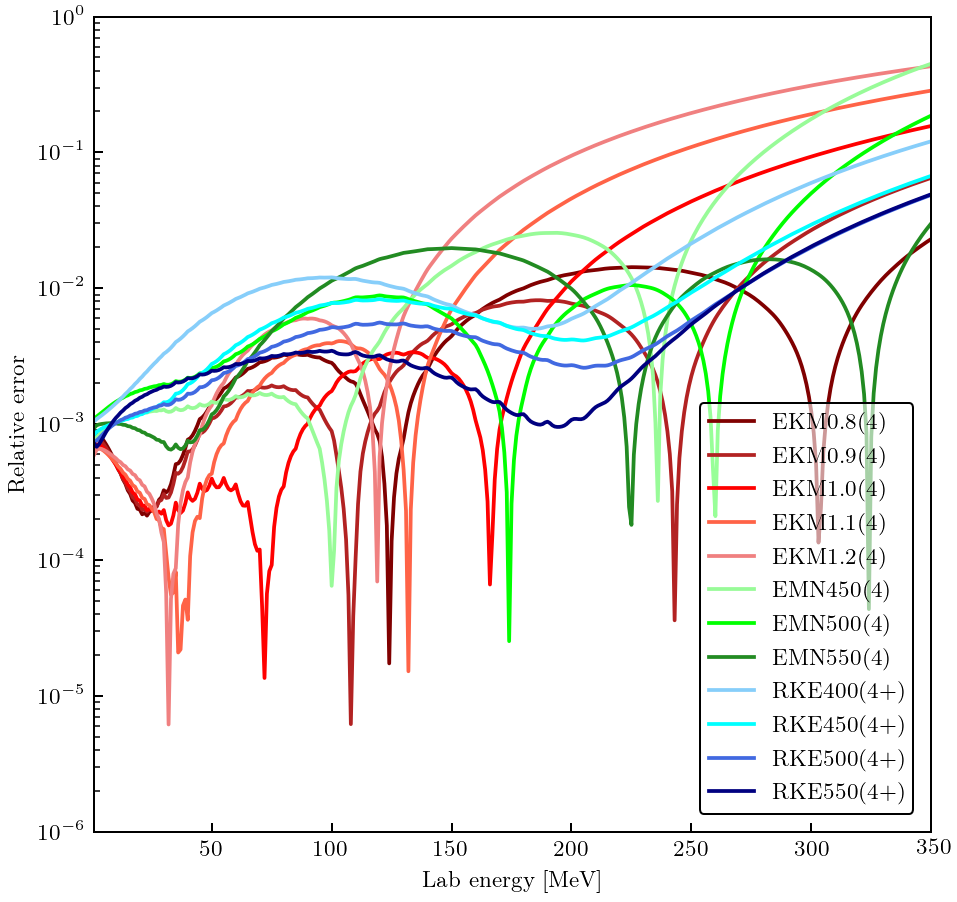

In [16]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_ylim(1e-6, 1)

for i in range(len(links_array)):
    residue = abs( (SGT[i] - SGT_nn_online) / SGT_nn_online )

    ax.plot(t_lab, residue, c = colors_array[i], label = labels_array[i])
    ax.legend()

ax.set_xlabel("Lab energy [MeV]")
ax.set_ylabel("Relative error")
ax.set_yscale('log')

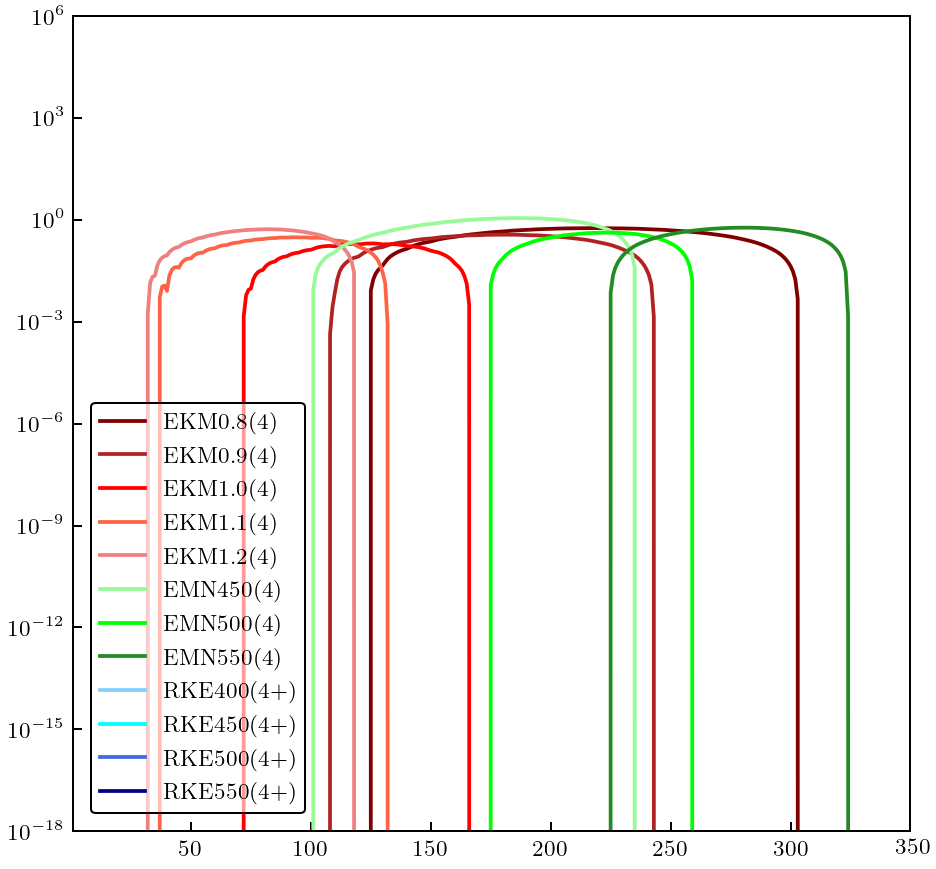

In [15]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_ylim(1e-18, 1e6)

for i in range(len(links_array)):
    residue = SGT[i] - SGT_nn_online

    ax.plot(t_lab, residue, c = colors_array[i], label = labels_array[i])
    ax.legend()

ax.set_yscale('log')